# $ \chi^2$ minimization code for the isochrone fitting

In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any, List
from scipy.interpolate import interp1d, RegularGridInterpolator
from scipy.spatial import cKDTree, KDTree
from scipy.spatial import cKDTree as ckdt
from scipy.optimize import minimize
from scipy.interpolate import NearestNDInterpolator
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
iso_folder = r'D:\Research\1.Magellanic-Bridge\project\codes\SMC2_analysis\iso_DR'
obs_csv = r'D:\Research\1.Magellanic-Bridge\project\codes\cluster_parameter_estimation\parameter_estimation\L114.csv'

clus_df = pd.read_csv(obs_csv)

<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ashis\AppData\Local\Temp\ipykernel_13968\3427379800.py:17: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel("\n $\delta$ ")


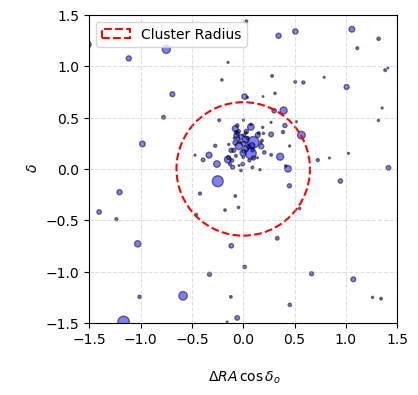

In [7]:
from matplotlib.patches import Circle
mag = clus_df['phot_g_mean_mag']
size  = (22 - mag).clip(lower = 0.2)**2
radius_min = 0.65

plt.figure(figsize=(4,4))
plt.scatter(clus_df['xcen'], clus_df['ycen'], s=size, c='blue', alpha=0.5, edgecolors='k')

scale_factor = 1
circle = Circle((0, 0), radius_min * scale_factor, edgecolor="red", fill=False, linewidth=1.5, linestyle="--", label="Cluster Radius")
plt.gca().add_patch(circle)

# Plot formatting
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("\n $ \\Delta RA \\, \\cos\\delta_o$ ")
plt.ylabel("\n $\delta$ ")

plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.gca().set_aspect('equal', adjustable='box')

# Save figure
# savepath = os.path.join(gaia_folder, f"{object_name}_spatial_xy.png")
# plt.savefig('BS220_spatial.png', dpi=300, bbox_inches="tight")
plt.show()

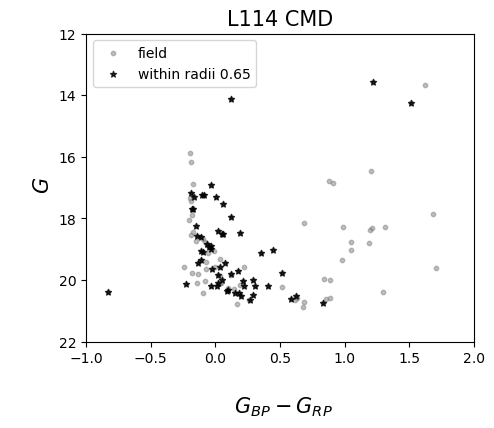

In [9]:
from astropy.coordinates import SkyCoord
import astropy.units as u

ra = 27.58
dec = -74.36

clus_df = pd.read_csv(obs_csv)
clus_coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
star_coords = SkyCoord(ra=clus_df['ra'].values*u.deg, dec=clus_df['dec'].values*u.deg, frame='icrs')

separations = clus_coord.separation(star_coords)
clus_df['sep_arcmin'] = separations.arcmin

within_cluster = clus_df[clus_df['sep_arcmin'] <= (0.65)]

# For plotting the CMD of the cluster members and field stars

plt.figure(figsize=(5, 4))
plt.scatter((clus_df['phot_bp_mean_mag'] - clus_df['phot_rp_mean_mag']), clus_df['phot_g_mean_mag'], s=10, c='grey', alpha=0.5, label='field')
plt.scatter((within_cluster['phot_bp_mean_mag']-within_cluster['phot_rp_mean_mag']), within_cluster['phot_g_mean_mag'], s=20, marker = "*", c='black', alpha=0.8, label='within radii 0.65')
plt.gca().invert_yaxis()  # Magnitude axis inverted
plt.xlim(-1.0, 2.0) 
plt.ylim(22, 12)
plt.xlabel('\n ${G_{BP} - G_{RP}}$', fontsize = 15)
plt.ylabel( '\n ${G}$', fontsize = 15)
plt.title('L114 CMD', fontsize = 15)
plt.legend()
plt.show()

In [30]:
obs = pd.read_csv(obs_csv)
# -------------------------------------------------------
# Replace these with your real CMD data
# -------------------------------------------------------
color = obs['phot_bp_mean_mag'] - obs['phot_rp_mean_mag']
mag   = obs['phot_g_mean_mag']

In [24]:
class KDNode:
    def __init__(self, point, axis, left=None, right=None):
        self.point = point  # (col, mag)
        self.axis = axis    # 0 for color, 1 for mag
        self.left = left
        self.right = right

def build_kdtree(points, depth=0):
    if len(points) == 0:
        return None

    axis = depth % 2  # only 2D here: 0=color, 1=mag
    pts_sorted = points[points[:, axis].argsort()]
    median = len(pts_sorted) // 2

    return KDNode(
        point=pts_sorted[median],
        axis=axis,
        left=build_kdtree(pts_sorted[:median], depth + 1),
        right=build_kdtree(pts_sorted[median+1:], depth + 1)
    )

In [25]:
def plot_tree_splits(node, xmin, xmax, ymin, ymax):
    if node is None:
        return

    x, y = node.point
    axis = node.axis

    if axis == 0:  # split on color → vertical line
        plt.plot([x, x], [ymin, ymax], 'r--', alpha=0.5)
        plot_tree_splits(node.left, xmin, x, ymin, ymax)
        plot_tree_splits(node.right, x, xmax, ymin, ymax)

    else:  # split on magnitude → horizontal line
        plt.plot([xmin, xmax], [y, y], 'b--', alpha=0.5)
        plot_tree_splits(node.left, xmin, xmax, ymin, y)
        plot_tree_splits(node.right, xmin, xmax, y, ymax)


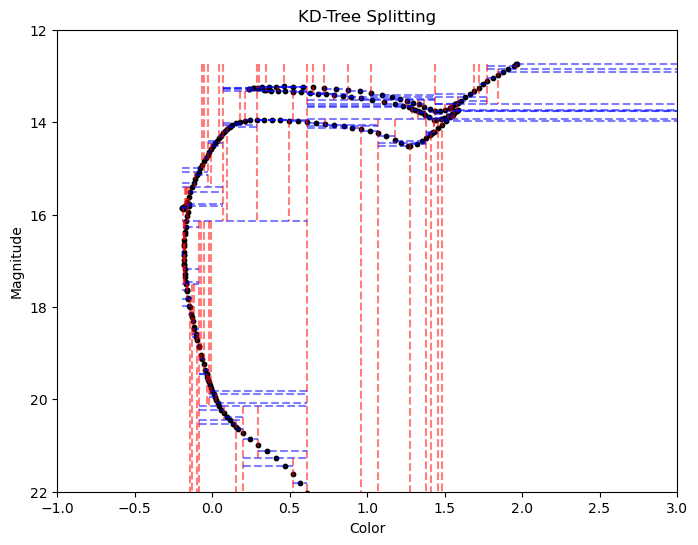

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

iso = pd.read_csv(r'C:\Users\ashis\OneDrive\Desktop\iso.csv')

iso_col = iso['G_BPmag'] - iso['G_RPmag'] + 0.1
iso_mag = iso['Gmag'] + 18.17
iso_pts = np.column_stack([iso_col, iso_mag])

obs_xy = np.column_stack([obs_col, obs_mag])

mask = np.isfinite(obs_xy).all(axis=1)    # True if both col & mag are finite
obs_xy_clean = obs_xy[mask]

# obs_col = (obs['phot_bp_mean_mag'] - obs['phot_rp_mean_mag']).to_numpy()
# obs_mag = obs['phot_g_mean_mag'].to_numpy()

# Build mirror KD-tree
root = build_kdtree(iso_pts)

# Plot CMD + partitions
plt.figure(figsize=(8, 6))
plt.scatter(iso_col, iso_mag, s=10, color='black')

plt.gca().invert_yaxis()
plot_tree_splits(root, xmin=min(iso_col), xmax=max(iso_col),
                       ymin=min(iso_mag), ymax=max(iso_mag))
plt.xlim(-1,3)
plt.ylim(22,12)

plt.title("KD-Tree Splitting")
plt.xlabel("Color")
plt.ylabel("Magnitude")
plt.show()


In [34]:
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt

iso_pts = np.column_stack([iso_col, iso_mag])
tree = cKDTree(iso_pts)

dists, idxs = tree.query(obs_xy_clean, k=1)

nearest_iso_pts = iso_pts[idxs]

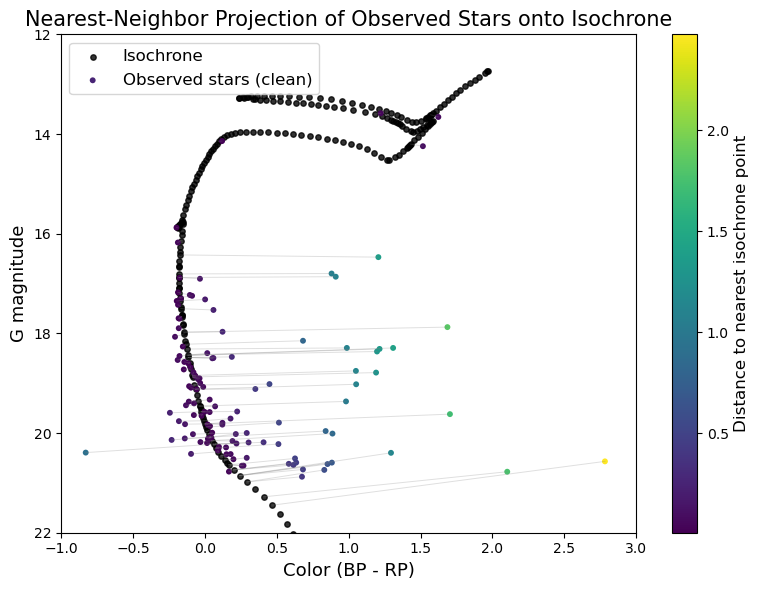

In [40]:
plt.figure(figsize=(8, 6))

# ----------------------------
# 1. PLOT ISOCHRONE
# ----------------------------
plt.scatter(
    iso_col, iso_mag,
    s=15, color="black", alpha=0.8,
    label="Isochrone"
)

# ----------------------------
# 2. PLOT CLEAN OBSERVED STARS
# ----------------------------
sc = plt.scatter(
    obs_xy_clean[:, 0], obs_xy_clean[:, 1],
    c=dists, cmap="viridis", s=18, edgecolor="none",
    label="Observed stars (clean)"
)

# ----------------------------
# 3. DRAW CONNECTION LINES
# Only draw lines for CLEAN stars
# ----------------------------
for i in range(len(obs_xy_clean)):
    plt.plot(
        [obs_xy_clean[i,0], nearest_iso_pts[i,0]],
        [obs_xy_clean[i,1], nearest_iso_pts[i,1]],
        color="gray", alpha=0.25, linewidth=0.7
    )

# ----------------------------
# 4. FORMAT CMD AXIS
# ----------------------------
plt.gca().invert_yaxis()
plt.xlim(-1,3)
plt.ylim(22, 12)
plt.xlabel("Color (BP - RP)", fontsize=13)
plt.ylabel("G magnitude", fontsize=13)
plt.title("Nearest-Neighbor Projection of Observed Stars onto Isochrone", fontsize=15)
# ----------------------------
# 5. COLORBAR + LEGEND
# ----------------------------
cbar = plt.colorbar(sc)
cbar.set_label("Distance to nearest isochrone point", fontsize=12)

plt.legend(loc="upper left", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ckdtree(tree, pts, xmin, xmax, ymin, ymax, node_index=0):
    """
    Recursively visualize the KD-tree splitting planes used by SciPy's cKDTree.
    Only works for 2D trees.
    """

    if node_index >= tree.nnodes:
        return

    node = tree.tree[node_index]
    axis = node.split_dim
    split = node.split

    # leaf nodes have split_dim == -1
    if axis == -1:
        return

    # splitting along color (x-axis)
    if axis == 0:
        plt.plot([split, split], [ymin, ymax], 'r--', alpha=0.5)
        # left child = values < split
        plot_ckdtree(tree, pts, xmin, split, ymin, ymax, node.less)
        # right child = values >= split
        plot_ckdtree(tree, pts, split, xmax, ymin, ymax, node.greater)

    # splitting along magnitude (y-axis)
    else:
        plt.plot([xmin, xmax], [split, split], 'b--', alpha=0.5)
        # lower child
        plot_ckdtree(tree, pts, xmin, xmax, ymin, split, node.less)
        # upper child
        plot_ckdtree(tree, pts, xmin, xmax, split, ymax, node.greater)

In [20]:
iso = pd.read_csv(r'C:\Users\ashis\OneDrive\Desktop\iso.csv')

iso_col = iso['G_BPmag'] - iso['G_RPmag'] + 0.1
iso_mag = iso['Gmag'] + 18.17

iso_pts = np.column_stack([iso_col, iso_mag])
tree = cKDTree(iso_pts)
print(tree)

In [45]:
import numpy as np
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d

def perpendicular_distances(obs_col, obs_mag, iso_col, iso_mag):
    """
    Compute perpendicular distances of observed stars to the isochrone polyline.
    Returns distances and projected points.
    """

    # Build KDTree on isochrone points to get nearest segments
    iso_pts = np.column_stack([iso_col, iso_mag])
    tree = cKDTree(iso_pts)

    n = len(obs_col)
    distances = np.zeros(n)

    for i in range(n):
        c, m = obs_col[i], obs_mag[i]

        # Find nearest isochrone point
        dist, idx = tree.query([c, m], k=1)

        # Form nearest segment
        if idx == 0:
            p0 = iso_pts[0]
            p1 = iso_pts[1]
        elif idx == len(iso_pts)-1:
            p0 = iso_pts[-2]
            p1 = iso_pts[-1]
        else:
            # choose closer of two possible segments
            d_left = np.linalg.norm([c, m] - iso_pts[idx-1])
            d_right = np.linalg.norm([c, m] - iso_pts[idx+1])
            if d_left < d_right:
                p0 = iso_pts[idx-1]
                p1 = iso_pts[idx]
            else:
                p0 = iso_pts[idx]
                p1 = iso_pts[idx+1]

        # vector math: projection onto segment
        v = p1 - p0
        w = np.array([c, m]) - p0
        t = np.dot(w, v) / np.dot(v, v)

        if t < 0: 
            proj = p0
        elif t > 1:
            proj = p1
        else:
            proj = p0 + t * v

        distances[i] = np.sqrt(np.sum((np.array([c, m]) - proj)**2))

    return distances

In [46]:
def sigma_clip_iso(obs_col, obs_mag, iso_col, iso_mag, sigma_level=1.5):

    dists = perpendicular_distances(obs_col, obs_mag, iso_col, iso_mag)

    # Robust estimate of σ (median absolute deviation)
    mad = np.median(np.abs(dists - np.median(dists)))
    sigma = 1.4826 * mad

    mask = dists <= sigma_level * sigma

    print(f"Sigma clipping: {np.sum(mask)} kept / {len(mask)} total (σ={sigma:.4f})")

    return mask, dists, sigma

In [ ]:
iso = pd.read_csv(r'C:\Users\ashis\OneDrive\Desktop\iso.csv')
obs_col = (obs['phot_bp_mean_mag'] - obs['phot_rp_mean_mag']).to_numpy()
obs_mag = obs["phot_g_mean_mag"].to_numpy()

iso_col = iso['G_BPmag'] - iso['G_RPmag'] + 0.1
iso_mag = iso['Gmag'] + 18.17

In [ ]:
mask, dists, sigma = sigma_clip_iso(obs_col, obs_mag, iso_col, iso_mag, sigma_level=1.5)

obs_col_clean = obs_col[mask]
obs_mag_clean = obs_mag[mask]

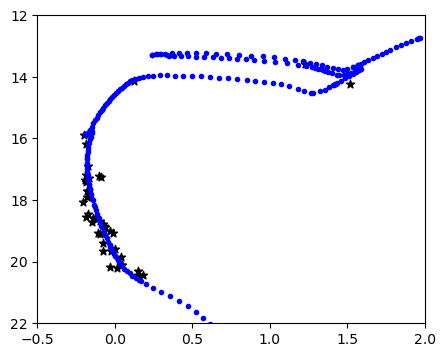

In [13]:
plt.figure(figsize=(5,4))
plt.scatter(obs_col_clean, obs_mag_clean, color="k", marker = "*")
plt.plot(iso_col, iso_mag, "b.")
plt.xlim(-0.5, 2.0)
plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.show()

In [41]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree

# -------------------------------------------------------
# 1. Function: Perpendicular distances
# -------------------------------------------------------
def perpendicular_distances(obs_col, obs_mag, iso_col, iso_mag):
    iso_pts = np.column_stack([iso_col, iso_mag])
    tree = cKDTree(iso_pts)

    n = len(obs_col)
    distances = np.zeros(n)

    for i in range(n):
        c, m = obs_col[i], obs_mag[i]

        dist, idx = tree.query([c, m], k=1)

        if idx == 0:
            p0, p1 = iso_pts[0], iso_pts[1]
        elif idx == len(iso_pts) - 1:
            p0, p1 = iso_pts[-2], iso_pts[-1]
        else:
            d_left = np.linalg.norm([c, m] - iso_pts[idx - 1])
            d_right = np.linalg.norm([c, m] - iso_pts[idx + 1])
            if d_left < d_right:
                p0, p1 = iso_pts[idx - 1], iso_pts[idx]
            else:
                p0, p1 = iso_pts[idx], iso_pts[idx + 1]

        v = p1 - p0
        w = np.array([c, m]) - p0
        t = np.dot(w, v) / np.dot(v, v)

        if t < 0:
            proj = p0
        elif t > 1:
            proj = p1
        else:
            proj = p0 + t * v

        distances[i] = np.linalg.norm(np.array([c, m]) - proj)

    return distances

# -------------------------------------------------------
# 2. Function: Sigma clipping
# -------------------------------------------------------
def sigma_clip_iso(obs_col, obs_mag, iso_col, iso_mag, sigma_level=1.5):

    dists = perpendicular_distances(obs_col, obs_mag, iso_col, iso_mag)

    mad = np.median(np.abs(dists - np.median(dists)))
    sigma = 1.4826 * mad

    mask = dists <= sigma_level * sigma

    print(f"Sigma clipping: {np.sum(mask)} kept / {len(mask)} total (σ={sigma:.4f})")

    return mask, dists, sigma

# -------------------------------------------------------
# 3. Load observational data
# -------------------------------------------------------
obs_csv = r'D:\Research\1.Magellanic-Bridge\project\codes\cluster_parameter_estimation\parameter_estimation\L114_50.csv'
obs = pd.read_csv(obs_csv)

obs_col = (obs['phot_bp_mean_mag'] - obs['phot_rp_mean_mag']).to_numpy()
obs_mag = obs["phot_g_mean_mag"].to_numpy()

# -------------------------------------------------------
# 4. Load isochrone
# -------------------------------------------------------
iso = pd.read_csv(r'C:\Users\ashis\OneDrive\Desktop\iso.csv')

iso_col = iso['G_BPmag'] - iso['G_RPmag'] + 0.1
iso_mag = iso['Gmag'] + 18.17

# -------------------------------------------------------
# 5. Sigma clipping
# -------------------------------------------------------
mask, dists, sigma = sigma_clip_iso(obs_col, obs_mag, iso_col, iso_mag, sigma_level=1.5)

# -------------------------------------------------------
# 6. Save *all original columns* for cleaned stars
# -------------------------------------------------------
clean_df = obs[mask].copy()

output_path = r"D:\Research\1.Magellanic-Bridge\project\codes\cluster_parameter_estimation\parameter_estimation\L114_50_cleaned.csv"

clean_df.to_csv(output_path, index=False)

print(f"\nFull cleaned dataset saved to:\n{output_path}")

Sigma clipping: 41 kept / 63 total (σ=0.0687)

Full cleaned dataset saved to:
D:\Research\1.Magellanic-Bridge\project\codes\cluster_parameter_estimation\parameter_estimation\L114_50_cleaned.csv


In [42]:
cleaned_csv = r'D:\Research\1.Magellanic-Bridge\project\codes\cluster_parameter_estimation\parameter_estimation\L114_50_cleaned.csv'
obs_clean = pd.read_csv(cleaned_csv)
print(obs_clean.columns)

Index(['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_g_mean_mag_error',
       'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error', 'xcen', 'ycen',
       'mag_psf', 'merr_psf', 'sharp_psf', 'density'],
      dtype='object')


In [50]:
#!/usr/bin/env python3
"""
Isochrone Parameter Estimation AFTER 1.5σ Clipping
---------------------------------------------------

Input:
  - cleaned CMD (col, mag, col_err, mag_err)
  - folder of isochrones (PARSEC/Gaia DR3 format)
Output:
  - best-fit age, metallicity, DM, A_G
  - χ² map, uncertainties
  - best-fit CMD plot
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os

from scipy.interpolate import interp1d, RegularGridInterpolator
from scipy.optimize import minimize
from scipy.spatial import cKDTree


# ===============================================================
# USER SETTINGS
# ===============================================================


Ns       = 240       # isochrone resampling resolution
Na_grid  = 9         # coarse grid age points
Nz_grid  = 7         # coarse Z points

DM_min, DM_max = 18.0, 19.5
AG_min, AG_max = 0.00, 0.836

VIS_MIN_MAG = 8.0
VIS_MAX_MAG = 25.0

sigma_floor_mag = 0.02
sigma_floor_col = 0.01

model_err_mag = 0.05      # recommended for Gaia
model_err_col = 0.03

# Δχ² thresholds for 2 parameters
DELTA_CHI2_1SIG_2PARAM = 2.30
DELTA_CHI2_2SIG_2PARAM = 6.17


# ===============================================================
# LOAD CLEANED OBSERVED CMD
# ===============================================================

def load_cleaned_csv(path):
    df = pd.read_csv(path)
    return {
        "col": (df["phot_bp_mean_mag"]- df["phot_rp_mean_mag"]).to_numpy(),
        "mag": df["phot_g_mean_mag"].to_numpy(),
        "col_err": df["phot_bp_mean_mag_error"] - df["phot_rp_mean_mag_error"].to_numpy(),
        "mag_err": df["phot_g_mean_mag_error"].to_numpy(),
    }


# ===============================================================
# LOAD ISOCHRONES + RESAMPLING
# ===============================================================

def load_isochrones_with_metadata(folder: str) -> List[Dict[str, Any]]:
    iso_list = []
    for path in sorted(glob.glob(os.path.join(folder, "*.dat"))):
        try:
            data = pd.read_csv(path, sep=r"\s+", comment="#", engine="python")
        except Exception as e:
            print(f"Could not read {path}: {e}")
            continue

        # --- Required columns in YOUR files ---
        required = ["logAge", "Zini", "Gmag", "G_BPmag", "G_RPmag"]
        if not all(col in data.columns for col in required):
            print(f"Skipping {path} → Missing one of {required}")
            continue

        # Extract photometry
        color = (data["G_BPmag"] - data["G_RPmag"]).to_numpy()
        Gmag = data["Gmag"].to_numpy()

        # Drop NaNs
        ok = np.isfinite(color) & np.isfinite(Gmag)
        color = color[ok]
        Gmag  = Gmag[ok]

        if len(color) < 3:
            continue  # not enough points to resample

        # Metadata
        logAge_val = float(np.unique(data["logAge"])[0])
        Z_val      = float(np.unique(data["Zini"])[0])   # <-- FIXED HERE

        iso_list.append({
            "file": os.path.basename(path),
            "logAge": logAge_val,
            "Z": Z_val,
            "color": color,
            "G": Gmag
        })

    print(f"Loaded {len(iso_list)} isochrones.")
    return iso_list


def resample_isochrones(isochrones, Ns_local=240):
    """
    Robust resampling for PARSEC isochrones – never collapses to <3 points.
    """
    s_grid = np.linspace(0, 1, Ns_local)
    resampled = []

    for iso in isochrones:
        col = iso["color"]
        mag = iso["G"]

        # Remove NaNs
        ok = np.isfinite(col) & np.isfinite(mag)
        col = col[ok]
        mag = mag[ok]

        if len(col) < 3:
            continue

        # Compute cumulative arc-length
        dx = np.diff(col)
        dy = np.diff(mag)
        seg = np.sqrt(dx*dx + dy*dy)

        cum = np.concatenate([[0], np.cumsum(seg)])

        # If total length is zero → make a simple param
        if cum[-1] == 0:
            cum = np.linspace(0,1,len(col))

        s_orig = cum / cum[-1]

        # Force monotonic increasing (remove duplicates)
        _, uniq_idx = np.unique(s_orig, return_index=True)
        s_orig = s_orig[uniq_idx]
        col = col[uniq_idx]
        mag = mag[uniq_idx]

        # Still not enough?
        if len(col) < 3:
            continue

        # Build interpolators
        f_col = interp1d(s_orig, col, kind='linear', fill_value="extrapolate")
        f_mag = interp1d(s_orig, mag, kind='linear', fill_value="extrapolate")

        col_s = f_col(s_grid)
        mag_s = f_mag(s_grid)

        resampled.append({
            "file": iso["file"],
            "logAge": iso["logAge"],
            "Z": iso["Z"],
            "color_s": col_s,
            "G_s": mag_s
        })

    print(f"Resampled {len(resampled)} / {len(isochrones)} isochrones.")

    return resampled



# ===============================================================
# BUILD INTERPOLATION CUBE (age, Z, s)
# ===============================================================

def build_interpolators(resampled):
    """
    Build a regular interpolation cube from an irregular set of isochrones.
    Uses nearest-neighbor fill for missing (age, Z) combinations.
    """

    # Collect all ages and Z values
    ages = sorted(list({iso["logAge"] for iso in resampled}))
    Zs   = sorted(list({iso["Z"]      for iso in resampled}))

    ages = np.array(ages)
    Zs   = np.array(Zs)

    print("Unique ages =", len(ages))
    print("Unique metallicities =", len(Zs))

    Ns_local = len(resampled[0]["color_s"])

    # Allocate interpolation cubes
    col_cube = np.full((len(ages), len(Zs), Ns_local), np.nan)
    mag_cube = np.full((len(ages), len(Zs), Ns_local), np.nan)

    # Index each isochrone by age & Z
    age_to_idx = {age: i for i, age in enumerate(ages)}
    Z_to_idx   = {z:   j for j, z   in enumerate(Zs)}

    # Fill known grid points
    for iso in resampled:
        ia = age_to_idx[iso["logAge"]]
        iz = Z_to_idx[iso["Z"]]
        col_cube[ia, iz, :] = iso["color_s"]
        mag_cube[ia, iz, :] = iso["G_s"]

    # Fill missing cells with nearest available
    from scipy.spatial import cKDTree
    ageZ_pairs = []
    filled_idx = []

    for ia in range(len(ages)):
        for iz in range(len(Zs)):
            if np.all(np.isfinite(col_cube[ia, iz, :])):
                ageZ_pairs.append([ages[ia], Zs[iz]])
                filled_idx.append((ia, iz))

    tree = cKDTree(np.array(ageZ_pairs))

    for ia in range(len(ages)):
        for iz in range(len(Zs)):
            if np.all(np.isfinite(col_cube[ia, iz, :])):
                continue
            dist, nn = tree.query([ages[ia], Zs[iz]])
            src_ia, src_iz = filled_idx[nn]
            col_cube[ia, iz, :] = col_cube[src_ia, src_iz, :]
            mag_cube[ia, iz, :] = mag_cube[src_ia, src_iz, :]

    # Build actual interpolators
    s_grid = np.linspace(0, 1, Ns_local)
    rgi_color = RegularGridInterpolator((ages, Zs, s_grid), col_cube, bounds_error=False, fill_value=None)
    rgi_mag   = RegularGridInterpolator((ages, Zs, s_grid), mag_cube, bounds_error=False, fill_value=None)

    print("Interpolation cube complete.")
    print("Cube shape =", col_cube.shape)

    return rgi_color, rgi_mag, s_grid


# ===============================================================
# GET MODEL ISOCHRONE AT (age, Z)
# ===============================================================

def get_iso_at(age, Z, rgi_color, rgi_mag, s_grid):
    pts = np.column_stack([np.full_like(s_grid, age),
                           np.full_like(s_grid, Z),
                           s_grid])
    return rgi_color(pts), rgi_mag(pts)


# ===============================================================
# PERPENDICULAR DISTANCE MATCHING
# ===============================================================

def distances_to_iso_perp(obs_col, obs_mag, iso_col, iso_mag):
    iso = np.column_stack([iso_col, iso_mag])
    tree = cKDTree(iso)

    dists, idx = tree.query(np.column_stack([obs_col, obs_mag]), k=1)

    proj = iso[idx]
    proj_col = proj[:,0]
    proj_mag = proj[:,1]

    return dists, proj_col, proj_mag


# ===============================================================
# CHI-SQUARE FUNCTION
# ===============================================================

def chi2_for(age, Z, DM, AG, obs, rgi_color, rgi_mag, s_grid):

    iso_col_s, iso_mag_s = get_iso_at(age, Z, rgi_color, rgi_mag, s_grid)

    # extinction conversion
    AV = AG / 0.789
    E  = 0.449 * AV

    model_col = iso_col_s + E
    model_mag = iso_mag_s + DM + AG

    d, pc, pm = distances_to_iso_perp(obs["col"], obs["mag"],
                                      model_col, model_mag)

    delta_c = obs["col"] - pc
    delta_m = obs["mag"] - pm

    sig_c = np.sqrt((obs["col_err"])**2 + model_err_col**2)
    sig_m = np.sqrt((obs["mag_err"])**2 + model_err_mag**2)

    return np.sum((delta_c/sig_c)**2 + (delta_m/sig_m)**2)


# ===============================================================
# GRID SEARCH (AGE, Z)
# ===============================================================

def scan_ageZ(obs, rgi_color, rgi_mag, s_grid):

    ages = rgi_color.grid[0]
    Zs   = rgi_color.grid[1]

    age_grid = np.linspace(ages.min(), ages.max(), Na_grid)
    Z_grid   = np.linspace(Zs.min(),   Zs.max(),   Nz_grid)

    results = []

    for age in age_grid:
        for Z in Z_grid:

            def objective(x):
                return chi2_for(age, Z, x[0], x[1], obs,
                                rgi_color, rgi_mag, s_grid)

            x0 = np.array([(DM_min + DM_max)/2,
                           (AG_min + AG_max)/2])

            res = minimize(objective, x0,
                           bounds=[(DM_min, DM_max), (AG_min, AG_max)],
                           method="L-BFGS-B")

            results.append({
                "age": age,
                "Z": Z,
                "DM": float(res.x[0]),
                "AG": float(res.x[1]),
                "chi2": float(res.fun)
            })

    best = min(results, key=lambda r: r["chi2"])
    return best, results


# ===============================================================
# REFINEMENT OF (DM, AG)
# ===============================================================

def refine_DM_AG(age, Zini, obs, rgi_color, rgi_mag, s_grid, DM0, AG0):

    def objective(x):
        return chi2_for(age, Zini, x[0], x[1], obs,
                        rgi_color, rgi_mag, s_grid)

    res = minimize(objective, np.array([DM0, AG0]),
                   bounds=[(DM_min, DM_max), (AG_min, AG_max)],
                   method="L-BFGS-B")

    return float(res.x[0]), float(res.x[1]), float(res.fun)


# ===============================================================
# MAIN
# ===============================================================

def main():

    print("Loading cleaned CMD...")
    obs = load_cleaned_csv(cleaned_csv)

    print("Loading isochrones...")
    iso_raw = load_isochrones(iso_folder)
    iso_res = resample_isochrones(iso_raw, Ns)

    print("Building interpolation cube...")
    rgi_color, rgi_mag, s_grid = build_interpolators(iso_res)

    print("Scanning age-Z grid...")
    coarse_best, all_results = scan_ageZ(obs, rgi_color, rgi_mag, s_grid)

    print("Coarse best:")
    print(coarse_best)

    print("Refining DM and AG...")
    DM_ref, AG_ref, chi2_min = refine_DM_AG(coarse_best["age"],
                                            coarse_best["Z"],
                                            obs,
                                            rgi_color, rgi_mag, s_grid,
                                            coarse_best["DM"],
                                            coarse_best["AG"])

    print("\n=== FINAL BEST-FIT PARAMETERS ===")
    print(f"logAge = {coarse_best['age']:.4f}")
    print(f"Z      = {coarse_best['Z']:.4f}")
    print(f"DM     = {DM_ref:.4f}")
    print(f"A_G    = {AG_ref:.4f}")
    print(f"chi²   = {chi2_min:.2f}")

    # ---- Plot final fit ----
    iso_col_s, iso_mag_s = get_iso_at(coarse_best["age"],
                                      coarse_best["Z"],
                                      rgi_color, rgi_mag, s_grid)

    AV = AG_ref / 0.789
    E  = 0.449 * AV

    model_col = iso_col_s + E
    model_mag = iso_mag_s + DM_ref + AG_ref

    plt.figure(figsize=(7,7))
    plt.scatter(obs["col"], obs["mag"], s=35, color="k", label="cleaned stars")
    plt.plot(model_col, model_mag, ".", color="red", label="best-fit iso")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.xlabel("BP-RP")
    plt.ylabel("G")
    plt.title("Best-fit Isochrone After Clipping")
    plt.tight_layout()
    plt.savefig("bestfit_isochrone_after_clipping.png", dpi=200)
    plt.show()


if __name__ == "__main__":
    main()

Loading cleaned CMD...
Loading isochrones...
Loaded 0 isochrones.
Resampled 0 / 0 isochrones.
Building interpolation cube...
Unique ages = 0
Unique metallicities = 0


IndexError: list index out of range

In [49]:
iso_raw = load_isochrones_with_metadata(iso_folder)
print("RAW ISOCHRONE COUNT =", len(iso_raw))

for i, iso in enumerate(iso_raw[:3]):
    print(f"ISO {i}: logAge={iso['logAge']}, Z={iso['Z']}, Npts={len(iso['color'])}")

iso_res = resample_isochrones(iso_raw, Ns)
print("RESAMPLED COUNT =", len(iso_res))

Loaded 1964 isochrones.
RAW ISOCHRONE COUNT = 1964
ISO 0: logAge=6.6, Z=0.004, Npts=158
ISO 1: logAge=6.61, Z=0.004, Npts=155
ISO 2: logAge=6.625, Z=0.004, Npts=158
Resampled 1964 / 1964 isochrones.
RESAMPLED COUNT = 1964


Observed stars after cleaning & G < 20 filter: 28
Iteration 1: kept 14 stars after 3.0σ clipping

Loading isochrones from: D:\Research\1.Magellanic-Bridge\project\codes\SMC2_analysis\iso_DR
Loaded 1964 isochrones.

Selecting best matching pre-existing isochrone (coarse) by weight coverage...

Search grids:
  ages (logAge) from 6.6 to 8.99501  -> 9 points
  Z from 0.003722 to 0.008 -> 7 points
  DM: 18.0 - 22 -> 21 points
  AG: 0.0 - 0.836 -> 21 points
Total combinations to evaluate: 27783 (this may take time)
Using seeds to reduce (age,Z) search: new 4 ages x 6 Z values
Finished age idx 1/4, Z idx 1/6; iterations done: 441
Finished age idx 1/4, Z idx 6/6; iterations done: 2646
Finished age idx 2/4, Z idx 5/6; iterations done: 4851
Finished age idx 3/4, Z idx 4/6; iterations done: 7056
Finished age idx 4/4, Z idx 3/6; iterations done: 9261

BEST FIT RESULT (grid search):
{'age': 6.6, 'Z': 0.007287, 'DM': 19.8, 'AG': 0.3762, 'E': 0.21408593155893535, 'chi2': 20.48104457359569, 'chi2_red'

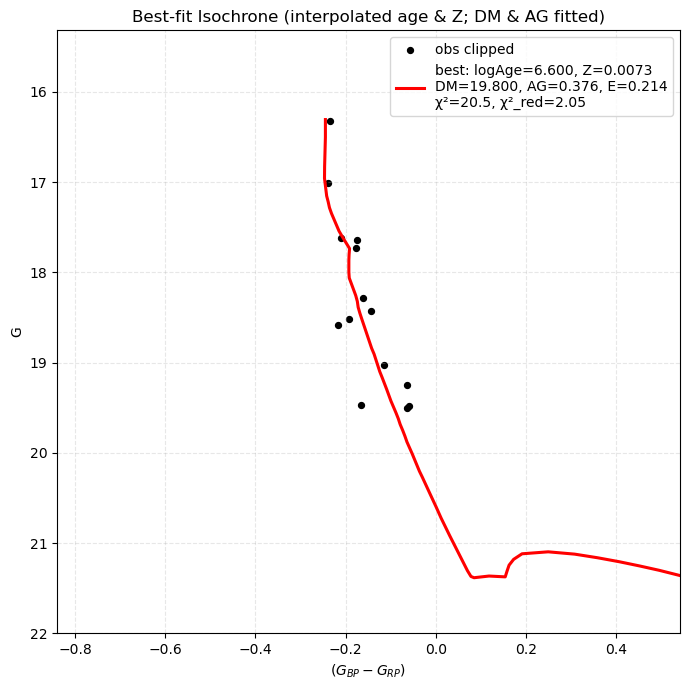

Saved summary to bestfit_ageZ_DM_AG_summary.json


In [18]:
# floors and clipping
sigma_floor_mag = 0.02
sigma_floor_col = 0.01
n_iter_clip = 3
sigma_clip = 3.0
min_valid = 3

# weight selection settings
weight_sigma = 0.05   # Gaussian sigma for coverage stage

# Grid resolutions (change to trade speed vs accuracy)
Na_grid = 9    # number of interpolated ages to try (e.g., 9)
Nz_grid = 7    # number of interpolated metallicities to try (e.g., 7)
NDM = 21       # number of DM samples between DM_min, DM_max (will be refined)
NAG = 21       # number of AG samples between AG_min, AG_max

# User requested DM and AG ranges
DM_min, DM_max = 18.0, 22
AG_min, AG_max = 0.0, 0.836

# s-resampling resolution along each isochrone
Ns = 240   # number of points to resample each isochrone to (higher => smoother, slower)

# -------------------------------------------------------------------------
# -------------------- 1) Load observed data & basic cleaning ----------------
# -------------------------------------------------------------------------
obs = pd.read_csv(obs_csv)

def pick_col(df, candidates, required=True):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of the candidate columns found: {candidates}")
    return None

col_G = pick_col(obs, ['phot_g_mean_mag', 'Gmag', 'V(G)', 'G', 'phot_g', 'V'], required=False)
col_color = pick_col(obs, ['bp_rp', 'BP-RP', '(BP-RP)', 'bp_rp_color', 'phot_bp_mean_mag_minus_phot_rp_mean_mag'], required=False)
col_bp = pick_col(obs, ['phot_bp_mean_mag', 'BPmag', 'BP'], required=False)
col_rp = pick_col(obs, ['phot_rp_mean_mag', 'RPmag', 'RP'], required=False)
col_Gerr = pick_col(obs, ['phot_g_mean_mag_error', 'G_ERR', 'Gerr', 'G_ERROR', 'G_err'], required=False)
col_BPerr = pick_col(obs, ['phot_bp_mean_mag_error', 'BP_ERR', 'BPerr', 'BP_ERROR', 'BP_err'], required=False)
col_RPerr = pick_col(obs, ['phot_rp_mean_mag_error', 'RP_ERR', 'RPerr', 'RP_ERROR', 'RP_err'], required=False)

if col_color is None and (col_bp and col_rp):
    obs['obs_color'] = obs[col_bp] - obs[col_rp]
    col_color = 'obs_color'

if col_G is None:
    raise KeyError("Could not find a G magnitude column in your observed file. Checked common names.")

if col_Gerr is None:
    print("No per-star G error column found. Using fallback sigma_floor_mag for all stars.")
    obs['G_err_fallback'] = sigma_floor_mag
    col_Gerr = 'G_err_fallback'

if (col_BPerr is None) or (col_RPerr is None):
    if 'color_err' in obs.columns:
        col_color_err = 'color_err'
    else:
        print(" BP_ERR or RP_ERR not found. Using fallback color error floor for all stars.")
        obs['color_err_fallback'] = sigma_floor_col
        col_color_err = 'color_err_fallback'
else:
    col_color_err = None

obs_mag = obs[col_G].to_numpy()
obs_mag_err = obs[col_Gerr].to_numpy()
if col_color in obs.columns:
    obs_col = obs[col_color].to_numpy()
else:
    obs_col = np.full_like(obs_mag, np.nan)

if col_color_err is None:
    if (col_BPerr in obs.columns) and (col_RPerr in obs.columns):
        bp_err_arr = obs[col_BPerr].to_numpy()
        rp_err_arr = obs[col_RPerr].to_numpy()
        obs_col_err = np.sqrt(bp_err_arr**2 + rp_err_arr**2)
    else:
        obs_col_err = np.full_like(obs_mag_err, sigma_floor_col)
else:
    obs_col_err = obs[col_color_err].to_numpy()

keep = (np.isfinite(obs_mag)) & (np.isfinite(obs_mag_err)) & (np.isfinite(obs_col)) & (np.isfinite(obs_col_err))
obs_mag = obs_mag[keep]
obs_mag_err = np.maximum(obs_mag_err[keep], sigma_floor_mag)
obs_col = obs_col[keep]
obs_col_err = np.maximum(obs_col_err[keep], sigma_floor_col)

mask_bright = obs_mag < 20
obs_mag = obs_mag[mask_bright]
obs_mag_err = obs_mag_err[mask_bright]
obs_col = obs_col[mask_bright]
obs_col_err = obs_col_err[mask_bright]

print(f"Observed stars after cleaning & G < 20 filter: {len(obs_mag)}")

# iterative ridge clipping (keeps previous behavior)
obs_mag_clip = obs_mag.copy()
obs_col_clip = obs_col.copy()
obs_mag_err_clip = obs_mag_err.copy()
obs_col_err_clip = obs_col_err.copy()

for iteration in range(n_iter_clip):
    if len(obs_col_clip) < 10:
        break
    bins = np.arange(np.nanmin(obs_col_clip), np.nanmax(obs_col_clip) + 0.1, 0.1)
    bin_idx = np.digitize(obs_col_clip, bins)
    medG, centers = [], []
    for i in range(1, len(bins)):
        sel = bin_idx == i
        if np.sum(sel) >= 2:
            medG.append(np.median(obs_mag_clip[sel]))
            centers.append(0.5 * (bins[i-1] + bins[i]))
        else:
            medG.append(np.nan)
            centers.append(0.5 * (bins[i-1] + bins[i]))
    medG = np.array(medG)
    centers = np.array(centers)
    good = ~np.isnan(medG)
    if np.sum(good) < 3:
        break

    ridge_func = interp1d(centers[good], medG[good], bounds_error=False, fill_value=np.nan)
    ridge_at_obs = ridge_func(obs_col_clip)
    residuals = obs_mag_clip - ridge_at_obs
    resid_std = np.nanstd(residuals)
    if np.isnan(resid_std) or resid_std == 0:
        break
    mask = np.abs(residuals) <= sigma_clip * resid_std

    obs_mag_clip = obs_mag_clip[mask]
    obs_col_clip = obs_col_clip[mask]
    obs_mag_err_clip = obs_mag_err_clip[mask]
    obs_col_err_clip = obs_col_err_clip[mask]
    print(f"Iteration {iteration+1}: kept {len(obs_mag_clip)} stars after {sigma_clip}σ clipping")

if len(obs_mag_clip) < min_valid:
    raise RuntimeError("Too few stars after clipping - adjust sigma_clip or check data.")

# -------------------------------------------------------------------------
# -------------------- 2) Load isochrones and resample to s ∈ [0,1] -----------
# -------------------------------------------------------------------------
def load_isochrones_with_metadata(folder):
    """
    Load all .dat files in folder. Each file must include columns for G, BP, RP,
    and also 'logAge' and 'Z' somewhere in the file (or derivable).
    Returns list of dicts: {file, logAge, Z, color_array, G_array}
    """
    iso_list = []
    print("\nLoading isochrones from:", folder)
    for path in sorted(glob.glob(os.path.join(folder, "*.dat"))):
        try:
            data = pd.read_csv(path, sep=r'\s+', comment="#", engine='python')
        except Exception as e:
            print(f"Could not read {path}: {e}")
            continue

        # try common names
        gcol = pick_col(data, ['Gmag', 'G', 'phot_g_mean_mag', 'g_mag'], required=False)
        bpcol = pick_col(data, ['G_BPbrmag', 'G_BPmag', 'phot_bp_mean_mag', 'bp_mag'], required=False)
        rpcol = pick_col(data, ['G_RPmag', 'phot_rp_mean_mag', 'rp_mag'], required=False)

        if (gcol is None) or (bpcol is None) or (rpcol is None):
            # skip file if mags not found
            print(f"Skipped {os.path.basename(path)}: missing G/BP/RP columns.")
            continue

        # get logAge, Z from file columns if present; else try to parse from filename
        if 'logAge' in data.columns:
            logAge_val = float(np.unique(data['logAge'])[0])
        else:
            # try parse from filename 'logAgeX' or similar -> fallback to nan
            logAge_val = float(data['logAge'][0]) if 'logAge' in data.columns else np.nan

        if 'Z' in data.columns:
            Z_val = float(np.unique(data['Z'])[0])
        else:
            Z_val = float(data['Z'][0]) if 'Z' in data.columns else np.nan

        # drop NaNs
        data = data.dropna(subset=[gcol, bpcol, rpcol])
        if len(data) < 3:
            continue

        color = (data[bpcol] - data[rpcol]).to_numpy()
        Gmag = data[gcol].to_numpy()

        # store
        iso_list.append({
            'file': os.path.basename(path),
            'logAge': logAge_val,
            'Z': Z_val,
            'color': color,
            'G': Gmag
        })
    print(f"Loaded {len(iso_list)} isochrones.")
    return iso_list

isochrones = load_isochrones_with_metadata(iso_folder)
if len(isochrones) == 0:
    raise RuntimeError("No isochrones loaded. Check formats and columns (G, BP, RP, logAge, Z).")

# check uniqueness of (logAge,Z)
pairs = [(iso['logAge'], iso['Z']) for iso in isochrones]
unique_pairs = set(pairs)
if len(unique_pairs) < 4:
    print("Warning: few unique (logAge,Z) combinations found. Interpolation might be poor.")

# create resampled isochrones on s ∈ [0,1]
s_grid = np.linspace(0.0, 1.0, Ns)
resampled = []  # each entry: dict with logAge, Z, color_s, G_s
for iso in isochrones:
    color = iso['color']
    Gmag = iso['G']
    # remove NaNs and duplicates
    ok = np.isfinite(color) & np.isfinite(Gmag)
    color = color[ok]
    Gmag = Gmag[ok]
    if len(color) < 3:
        continue

    # compute cumulative arc-length along CMD (color vs G)
    dx = np.diff(color)
    dy = np.diff(Gmag)
    seglen = np.sqrt(dx*dx + dy*dy)
    cum = np.concatenate(([0.0], np.cumsum(seglen)))
    if cum[-1] == 0:
        # degenerate, spread artificially
        cum = np.linspace(0,1,len(color))
    s_orig = cum / cum[-1]

    # need strictly increasing s_orig for interp1d
    # if duplicates exist, compress indices
    _, uniq_idx = np.unique(s_orig, return_index=True)
    s_orig_u = s_orig[np.sort(uniq_idx)]
    color_u = color[np.sort(uniq_idx)]
    Gmag_u = Gmag[np.sort(uniq_idx)]
    if len(s_orig_u) < 3:
        continue

    f_col = interp1d(s_orig_u, color_u, kind='linear', bounds_error=False, fill_value='extrapolate')
    f_G = interp1d(s_orig_u, Gmag_u, kind='linear', bounds_error=False, fill_value='extrapolate')
    color_s = f_col(s_grid)
    G_s = f_G(s_grid)

    resampled.append({
        'file': iso['file'],
        'logAge': iso['logAge'],
        'Z': iso['Z'],
        'color_s': color_s,
        'G_s': G_s
    })

if len(resampled) == 0:
    raise RuntimeError("No valid resampled isochrones. Check data quality.")

# -------------------------------------------------------------------------
# -------------------- 3) Build regular grid in (logAge, Z, s) -------------
# -------------------------------------------------------------------------
# unique sorted grid points
logAge_vals = np.array(sorted(list({r['logAge'] for r in resampled if np.isfinite(r['logAge'])})))
Z_vals = np.array(sorted(list({r['Z'] for r in resampled if np.isfinite(r['Z'])})))

if len(logAge_vals) < 2 or len(Z_vals) < 2:
    print("Warning: not enough distinct ages or metallicities for smooth 2D interpolation. We'll still attempt nearest filling.")

n_age = len(logAge_vals)
n_Z = len(Z_vals)

# initialize cubes with NaNs
color_cube = np.full((n_age, n_Z, Ns), np.nan)
mag_cube = np.full((n_age, n_Z, Ns), np.nan)

# fill available entries
for r in resampled:
    if (not np.isfinite(r['logAge'])) or (not np.isfinite(r['Z'])):
        continue
    try:
        ia = int(np.where(logAge_vals == r['logAge'])[0][0])
        iz = int(np.where(Z_vals == r['Z'])[0][0])
    except Exception:
        # if logAge/Z not exactly matched due to float differences, find nearest index
        ia = int(np.argmin(np.abs(logAge_vals - r['logAge'])))
        iz = int(np.argmin(np.abs(Z_vals - r['Z'])))
    color_cube[ia, iz, :] = r['color_s']
    mag_cube[ia, iz, :] = r['G_s']

# For any missing grid cells, fill by nearest neighbour in (age,Z) for each s slice
# Build list of available (age,Z) points
available_pts = []
for ia in range(n_age):
    for iz in range(n_Z):
        if np.all(np.isfinite(color_cube[ia,iz,:])):
            available_pts.append((logAge_vals[ia], Z_vals[iz], ia, iz))
available_pts = np.array(available_pts)
if available_pts.size == 0:
    raise RuntimeError("No complete grid points available to fill the interpolation cube.")

ageZ_xy = available_pts[:, :2]
ia_list = available_pts[:,2].astype(int)
iz_list = available_pts[:,3].astype(int)

from scipy.spatial import cKDTree as cKD
ageZ_tree = cKD(ageZ_xy)

# Fill missing by nearest neighbor per s
for ia in range(n_age):
    for iz in range(n_Z):
        if np.all(np.isfinite(color_cube[ia,iz,:])):
            continue
        # query nearest available (age,Z)
        query = np.array([logAge_vals[ia], Z_vals[iz]])
        _, nn = ageZ_tree.query(query, k=1)
        nn = int(nn)
        src_ia = ia_list[nn]
        src_iz = iz_list[nn]
        color_cube[ia,iz,:] = color_cube[src_ia, src_iz, :]
        mag_cube[ia,iz,:] = mag_cube[src_ia, src_iz, :]

# Now we have full color_cube and mag_cube on a regular (age, Z, s) grid
# Prepare RegularGridInterpolator for color and mag: grid axes are (logAge_vals, Z_vals, s_grid)
from scipy.interpolate import RegularGridInterpolator as RGI
rgi_color = RGI((logAge_vals, Z_vals, s_grid), color_cube, bounds_error=False, fill_value=None)
rgi_mag = RGI((logAge_vals, Z_vals, s_grid), mag_cube, bounds_error=False, fill_value=None)

# -------------------------------------------------------------------------
# -------------------- 4) Helper: get interpolated isochrone at (age,Z) ----
# -------------------------------------------------------------------------
def get_iso_at(age, Z):
    """
    Return (color_arr, G_arr) arrays of length Ns for isochrone interpolated to (age, Z).
    """
    # build points for all s values: shape (Ns, 3)
    pts = np.zeros((Ns, 3))
    pts[:,0] = age
    pts[:,1] = Z
    pts[:,2] = s_grid
    color_interp = rgi_color(pts)
    mag_interp = rgi_mag(pts)
    return color_interp, mag_interp

# -------------------------------------------------------------------------
# -------------------- 5) Weight selection (as before) ----------------------
# -------------------------------------------------------------------------
def compute_weight_score(obs_col_arr, obs_mag_arr, iso_col_arr, iso_mag_arr, sigma=0.05):
    pts_iso = np.column_stack([iso_col_arr, iso_mag_arr])
    tree = cKDTree(pts_iso)
    pts_obs = np.column_stack([obs_col_arr, obs_mag_arr])
    dists, _ = tree.query(pts_obs, k=1)
    w = np.exp(-(dists**2) / (2.0 * sigma**2))
    return np.sum(w)

print("\nSelecting best matching pre-existing isochrone (coarse) by weight coverage...")

coverage_results = []
for r in resampled:
    # use the resampled curve as a representative
    col = r['color_s']
    mag = r['G_s']
    # baseline shift (use a reference DM and AG for scoring)
    DM_ref = (DM_min + DM_max)/2.0
    AG_ref = (AG_min + AG_max)/2.0
    # compute approximate E(BP-RP) from AG_ref -> AV -> E
    AV_ref = AG_ref / 0.789
    E_ref = 0.449 * AV_ref
    col_shift = col + E_ref
    mag_shift = mag + DM_ref + AG_ref
    # restrict visible
    vis = (mag_shift > 8) & (mag_shift < 25)
    if np.sum(vis) < 5:
        continue
    score = compute_weight_score(obs_col_clip, obs_mag_clip, col_shift[vis], mag_shift[vis], sigma=weight_sigma)
    coverage_results.append({
        'file': r['file'],
        'logAge': r['logAge'],
        'Z': r['Z'],
        'score': float(score)
    })

if len(coverage_results) == 0:
    print("No resampled isochrone passed the coarse coverage test; proceeding anyway with the interpolated grid.")

# optional: pick top N iso seeds to speed up search
coverage_results_sorted = sorted(coverage_results, key=lambda x: -x['score'])
seed_list = coverage_results_sorted[:5] if len(coverage_results_sorted) > 0 else []

# -------------------------------------------------------------------------
# -------------------- 6) Full fitting: scan (age, Z, DM, AG) -------------
# -------------------------------------------------------------------------
# Build search grids (interpolated ages/Z across available spans)
age_min, age_max = np.nanmin(logAge_vals), np.nanmax(logAge_vals)
Z_min, Z_max = np.nanmin(Z_vals), np.nanmax(Z_vals)

age_grid = np.linspace(age_min, age_max, Na_grid)
Z_grid = np.linspace(Z_min, Z_max, Nz_grid)
DM_grid = np.linspace(DM_min, DM_max, NDM)
AG_grid = np.linspace(AG_min, AG_max, NAG)

print("\nSearch grids:")
print(f"  ages (logAge) from {age_min} to {age_max}  -> {len(age_grid)} points")
print(f"  Z from {Z_min} to {Z_max} -> {len(Z_grid)} points")
print(f"  DM: {DM_min} - {DM_max} -> {len(DM_grid)} points")
print(f"  AG: {AG_min} - {AG_max} -> {len(AG_grid)} points")
total_iters = len(age_grid)*len(Z_grid)*len(DM_grid)*len(AG_grid)
print(f"Total combinations to evaluate: {total_iters} (this may take time)")

results = []
n_obs = len(obs_mag_clip)

# Optionally restrict age/Z grid to neighborhood of seed isochrones (speeds up search)
use_seeds = True if len(seed_list) > 0 else False
if use_seeds:
    # build mask keeping only grid points near seeds (within some fraction)
    keep_age = np.zeros_like(age_grid, dtype=bool)
    keep_Z = np.zeros_like(Z_grid, dtype=bool)
    # mark age/Z values within range of seeds ± full span/3
    for seed in seed_list:
        a, z = seed['logAge'], seed['Z']
        age_span = (age_max - age_min) / 3.0
        Z_span = (Z_max - Z_min) / 3.0
        keep_age |= (np.abs(age_grid - a) <= age_span)
        keep_Z |= (np.abs(Z_grid - z) <= Z_span)
    # if mask empty, fallback to full grid
    if not np.any(keep_age) or not np.any(keep_Z):
        keep_age[:] = True
        keep_Z[:] = True
    age_grid = age_grid[keep_age]
    Z_grid = Z_grid[keep_Z]
    print(f"Using seeds to reduce (age,Z) search: new {len(age_grid)} ages x {len(Z_grid)} Z values")

# Evaluate
iter_count = 0
best_so_far = None

for ia, age_val in enumerate(age_grid):
    for iz, Z_val in enumerate(Z_grid):
        # get interpolated isochrone at (age_val, Z_val) -- arrays length Ns
        iso_col_s, iso_mag_s = get_iso_at(age_val, Z_val)
        # restrict model points to useful magnitude range (avoid numerical oddities)
        # we will keep all points; KDTree matching will handle
        pts_model = np.column_stack([iso_col_s, iso_mag_s])

        # prebuild KDTree of model points (no DM/AG yet, we will shift magnitudes per DM/AG)
        # But DM & AG shift only affects magnitude and color (AG via E -> color shift and magnitude shift)
        # To avoid rebuild for each DM/AG we keep model arrays and shift them inside loops.
        for DM_val in DM_grid:
            for AG_val in AG_grid:
                iter_count += 1
                # convert AG -> AV -> E(BP-RP)
                AV_val = AG_val / 0.789
                E_val = 0.449 * AV_val

                model_col_shifted = iso_col_s + E_val
                model_mag_shifted = iso_mag_s + DM_val + AG_val

                # limit to reasonable magnitude range
                vis_mask = (model_mag_shifted > 8) & (model_mag_shifted < 25)
                if np.sum(vis_mask) < 5:
                    continue
                pts_model_vis = np.column_stack([model_col_shifted[vis_mask], model_mag_shifted[vis_mask]])
                tree = cKDTree(pts_model_vis)

                query_pts = np.column_stack([obs_col_clip, obs_mag_clip])
                try:
                    dists, idx = tree.query(query_pts, k=1, workers=-1)
                except TypeError:
                    dists, idx = tree.query(query_pts, k=1)

                matched_col = pts_model_vis[:,0][idx]
                matched_mag = pts_model_vis[:,1][idx]

                delta_col = obs_col_clip - matched_col
                delta_mag = obs_mag_clip - matched_mag

                sigma_col_arr = np.maximum(obs_col_err_clip, sigma_floor_col)
                sigma_mag_arr = np.maximum(obs_mag_err_clip, sigma_floor_mag)
                model_err_col = 0.01
                model_err_mag = 0.01
                sig_col = np.sqrt(sigma_col_arr**2 + model_err_col**2)
                sig_mag = np.sqrt(sigma_mag_arr**2 + model_err_mag**2)

                chi2 = np.sum((delta_col / sig_col)**2) + np.sum((delta_mag / sig_mag)**2)
                dof = max(n_obs - 4, 1)
                chi2_red = chi2 / dof

                if (best_so_far is None) or (chi2 < best_so_far['chi2']):
                    best_so_far = {
                        'age': float(age_val),
                        'Z': float(Z_val),
                        'DM': float(DM_val),
                        'AG': float(AG_val),
                        'E': float(E_val),
                        'chi2': float(chi2),
                        'chi2_red': float(chi2_red),
                        'matched_col': matched_col,
                        'matched_mag': matched_mag
                    }

                # optionally store top N results (we store only best for brevity)
        # simple progress print
        if (ia*len(Z_grid) + iz) % 5 == 0:
            print(f"Finished age idx {ia+1}/{len(age_grid)}, Z idx {iz+1}/{len(Z_grid)}; iterations done: {iter_count}")

if best_so_far is None:
    raise RuntimeError("No valid fit found in the scanned parameter space.")

best = best_so_far
print("\nBEST FIT RESULT (grid search):")
print(best)

# compute distance
distance_pc = 10.0 ** ((best['DM'] + 5.0)/5.0)
distance_kpc = distance_pc / 1000.0

print(f"Distance (pc): {distance_pc:.0f}  ({distance_kpc:.3f} kpc)")
print(f"Final E(BP-RP) = {best['E']:.4f}")

# -------------------------------------------------------------------------
# -------------------- 7) Plot best-fit isochrone + diagnostics -------------
# -------------------------------------------------------------------------
best_color_s, best_mag_s = get_iso_at(best['age'], best['Z'])
best_color_shifted = best_color_s + best['E']
best_mag_shifted = best_mag_s + best['DM'] + best['AG']

plt.figure(figsize=(7,7))
plt.scatter(obs_col_clip, obs_mag_clip, color='k', s=18, label='obs clipped')
plt.plot(best_color_shifted, best_mag_shifted, color='red', lw=2.2,
         label=(f"best: logAge={best['age']:.3f}, Z={best['Z']:.4f}\n"
                f"DM={best['DM']:.3f}, AG={best['AG']:.3f}, E={best['E']:.3f}\n"
                f"χ²={best['chi2']:.1f}, χ²_red={best['chi2_red']:.2f}"))
plt.gca().invert_yaxis()
plt.xlim(np.min(obs_col_clip) - 0.6, np.max(obs_col_clip) + 0.6)
plt.ylim(max(22, np.max(obs_mag_clip) + 1), np.min(obs_mag_clip) - 1)
plt.xlabel(r'$(G_{BP}-G_{RP})$')
plt.ylabel('G')
plt.legend()
plt.grid(ls='--', alpha=0.3)
plt.title('Best-fit Isochrone (interpolated age & Z; DM & AG fitted)')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# -------------------- 8) Save summary ------------------------------------
# -------------------------------------------------------------------------
out = {
    'best_age_logAge': best['age'],
    'best_Z': best['Z'],
    'best_DM': best['DM'],
    'best_AG': best['AG'],
    'best_E_BP_RP': best['E'],
    'chi2': best['chi2'],
    'chi2_red': best['chi2_red'],
    'distance_pc': distance_pc,
    'distance_kpc': distance_kpc
}
pd.Series(out).to_json('bestfit_ageZ_DM_AG_summary.json', orient='index')
print("Saved summary to bestfit_ageZ_DM_AG_summary.json")


Observed stars after G < 20 filter: 28
Iteration 1: kept 14 stars after 5σ clipping

🔍 Loading isochrones from: D:\Research\1.Magellanic-Bridge\project\codes\SMC2_analysis\iso_DR

✅ Loaded 1964 valid isochrones.

✅ Best Fit Isochrone Found:
{'file': 'iso_Z0.0045_logAge7.47.dat', 'Z': 0.004516, 'logAge': 7.47001, 'dms': -0.19999999999999996, 'es': -0.009999999999999995, 'chi2': 2.70838936171487, 'chi2_red': 0.22569911347623917, 'model_col_shifted': array([ 1.1077e+00,  1.0707e+00,  9.9470e-01,  9.7170e-01,  9.7070e-01,
        9.5270e-01,  8.9570e-01,  8.7770e-01,  8.4970e-01,  8.4870e-01,
        8.1870e-01,  8.0870e-01,  7.8170e-01,  7.7070e-01,  7.2770e-01,
        6.9870e-01,  6.8770e-01,  6.4770e-01,  6.0570e-01,  5.6070e-01,
        5.0670e-01,  4.4970e-01,  3.8970e-01,  3.3270e-01,  2.7970e-01,
        2.3470e-01,  1.9970e-01,  1.6970e-01,  1.4470e-01,  1.2270e-01,
        1.0570e-01,  8.9700e-02,  7.5700e-02,  6.3700e-02,  5.3700e-02,
        4.3700e-02,  3.5700e-02,  2.6700e-02

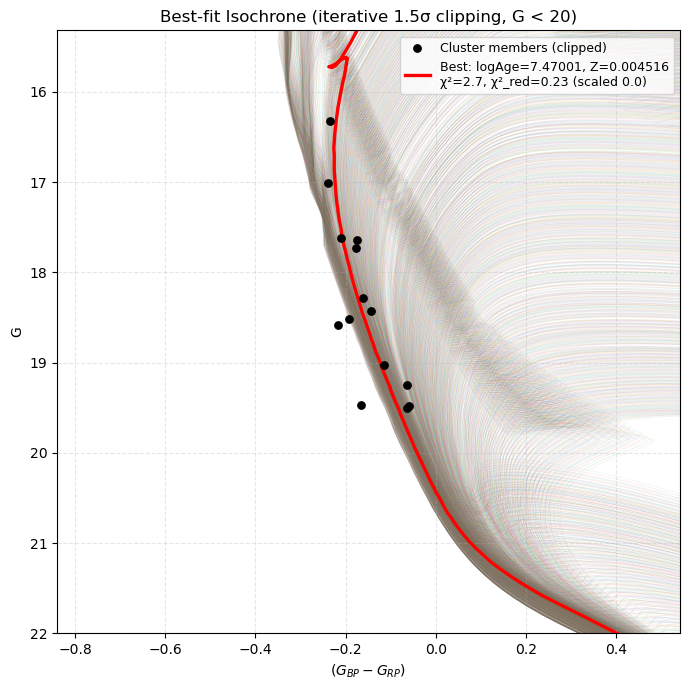

In [24]:
DM = 18.977          # base distance modulus
A_V = 0.3
A_G = 0.789 * A_V
E_BP_RP = 0.449 * A_V

# photometric uncertainties (tweak if you have real errors)
sigma_G = 0.15
sigma_col = 0.08

# expand DM search so model can become brighter if needed
dm_shifts = np.linspace(-1.5, 0.5, 41)  # allow up to -1.5 mag (brighter)
e_shifts  = np.linspace(-0.12, 0.12, 25)

n_iter_clip = 3
sigma_clip = 5
min_valid = 3

# -------------------------------------------------
# --- Load observed data ---
obs = pd.read_csv(obs_csv)
obs_mag = obs['phot_g_mean_mag'].to_numpy()    # Gmag
obs_col = (obs['phot_bp_mean_mag'] - obs['phot_rp_mean_mag']).to_numpy()    # (G_BP - G_RP)

keep = (np.isfinite(obs_mag)) & (np.isfinite(obs_col)) & (obs_mag > -30) & (obs_mag < 40)
obs_mag = obs_mag[keep]
obs_col = obs_col[keep]

# --- keep only relatively bright stars: G < 20 ---
mask_bright = obs_mag < 20
obs_mag = obs_mag[mask_bright]
obs_col = obs_col[mask_bright]

print(f"Observed stars after G < 20 filter: {len(obs_mag)}")

# --- iterative 1.5σ clipping around ridge line ---
obs_mag_clip = obs_mag.copy()
obs_col_clip = obs_col.copy()

for iteration in range(n_iter_clip):
    if len(obs_col_clip) < 10:
        break
    bins = np.arange(np.nanmin(obs_col_clip), np.nanmax(obs_col_clip) + 0.1, 0.1)
    bin_idx = np.digitize(obs_col_clip, bins)
    medG, centers = [], []
    for i in range(1, len(bins)):
        sel = bin_idx == i
        if np.sum(sel) >= 2:
            medG.append(np.median(obs_mag_clip[sel]))
            centers.append(0.5 * (bins[i-1] + bins[i]))
        else:
            medG.append(np.nan)
            centers.append(0.5 * (bins[i-1] + bins[i]))
    medG = np.array(medG)
    centers = np.array(centers)
    good = ~np.isnan(medG)
    if np.sum(good) < 3:
        break

    ridge_func = interp1d(centers[good], medG[good], bounds_error=False, fill_value=np.nan)
    ridge_at_obs = ridge_func(obs_col_clip)
    residuals = obs_mag_clip - ridge_at_obs
    resid_std = np.nanstd(residuals)
    if np.isnan(resid_std) or resid_std == 0:
        break
    mask = np.abs(residuals) <= sigma_clip * resid_std

    obs_mag_clip = obs_mag_clip[mask]
    obs_col_clip = obs_col_clip[mask]
    print(f"Iteration {iteration+1}: kept {len(obs_mag_clip)} stars after {sigma_clip}σ clipping")

if len(obs_mag_clip) < min_valid:
    raise RuntimeError("Too few stars after clipping - adjust sigma_clip or check data.")

# -------------------------------------------------
# --- Load Isochrones (matching your columns) ---
def load_isochrones(folder):
    isochrones = []
    print("\n🔍 Loading isochrones from:", folder)
    for path in sorted(glob.glob(os.path.join(folder, "*.dat"))):
        try:
            # use sep regex to avoid delim_whitespace deprecation
            data = pd.read_csv(path, sep=r'\s+', comment="#", engine='python')
        except Exception as e:
            print(f"⚠️ Could not read {path}: {e}")
            continue

        cols = set(data.columns)
        # your files have 'Gmag', 'G_BPbrmag', 'G_RPmag'
        if {'Gmag', 'G_BPmag', 'G_RPmag'}.issubset(cols):
            # drop rows with NaNs in required mags
            data = data.dropna(subset=['Gmag', 'G_BPmag', 'G_RPmag'])
            if len(data) >= 3:
                data['color'] = data['G_BPmag'] - data['G_RPmag']
                data['G'] = data['Gmag']
                iso = {
                    'file': os.path.basename(path),
                    'Z': np.unique(data['Z'])[0] if 'Z' in data.columns else np.nan,
                    'logAge': np.unique(data['logAge'])[0] if 'logAge' in data.columns else np.nan,
                    'color': data['color'].values,
                    'G': data['G'].values
                }
                isochrones.append(iso)
            else:
                print(f"Too few valid points in {path}, skipped.")
        else:
            print(f" Missing required columns in {path}, skipped. Columns: {list(data.columns)}")
    print(f"\n✅ Loaded {len(isochrones)} valid isochrones.")
    return isochrones

isochrones = load_isochrones(iso_folder)
if len(isochrones) == 0:
    raise RuntimeError("No valid isochrones found. Check column names or file format.")

# -------------------------------------------------
# --- Fit and χ² minimization (mask after shifting) ---
results = []
plt.figure(figsize=(7,7))

# plot observed clipped points early so axis autoscale includes them
plt.scatter(obs_col_clip, obs_mag_clip, color='k', s=28, label='Cluster members (clipped)', zorder=6)

for iso in isochrones:
    color_iso_raw = iso['color']
    mag_iso_raw = iso['G']

    # remove NaNs
    ok = np.isfinite(color_iso_raw) & np.isfinite(mag_iso_raw)
    color_iso_raw = color_iso_raw[ok]
    mag_iso_raw = mag_iso_raw[ok]
    if len(color_iso_raw) < 5:
        continue

    # --- base shift to apparent magnitudes (we will add small dms/es inside grid)
    model_col_base = color_iso_raw + E_BP_RP
    model_mag_base = mag_iso_raw + DM + A_G

    # mask by apparent mag but include bright end (down to G~8)
    vis_mask = (model_mag_base > 8) & (model_mag_base < 25)
    model_col = model_col_base[vis_mask]
    model_mag = model_mag_base[vis_mask]
    if len(model_col) < 5:
        continue

    # faint plotting of the base shifted isochrone for context
    plt.plot(model_col, model_mag, lw=0.5, alpha=0.08, zorder=0)

    best_local = None
    for dms in dm_shifts:
        for es in e_shifts:
            model_col_shifted = model_col + es             # small horizontal shift
            model_mag_shifted = model_mag + dms           # small vertical shift

            model_points = np.column_stack([model_col_shifted, model_mag_shifted])
            tree = cKDTree(model_points)

            # safe query: use workers if available
            query_pts = np.column_stack([obs_col_clip, obs_mag_clip])
            try:
                dists, idx = tree.query(query_pts, k=1, workers=-1)
            except TypeError:
                # older scipy does not have 'workers' arg
                dists, idx = tree.query(query_pts, k=1)

            matched_model_col = model_col_shifted[idx]
            matched_model_mag = model_mag_shifted[idx]

            # compute chi2 in both axes
            chi2_mag = np.sum(((obs_mag_clip - matched_model_mag) / sigma_G) ** 2)
            chi2_col = np.sum(((obs_col_clip - matched_model_col) / sigma_col) ** 2)
            chi2_total = chi2_mag + chi2_col
            n = len(obs_mag_clip)
            dof = max(n - 2, 1)
            chi2_red = chi2_total / dof

            if (best_local is None) or (chi2_total < best_local['chi2']):
                best_local = {
                    'file': iso['file'],
                    'Z': iso['Z'],
                    'logAge': iso['logAge'],
                    'dms': dms,
                    'es': es,
                    'chi2': float(chi2_total),
                    'chi2_red': float(chi2_red),
                    'model_col_shifted': model_col_shifted,
                    'model_mag_shifted': model_mag_shifted,
                    'matched_model_col': matched_model_col,
                    'matched_model_mag': matched_model_mag
                }
    if best_local:
        results.append(best_local)

if len(results) == 0:
    raise RuntimeError("No valid fit found. Check your magnitude or color limits or isochrone coverage.")

best_global = min(results, key=lambda x: x['chi2'])
print("\n✅ Best Fit Isochrone Found:")
print(best_global)

# diagnostics: range of best shifted model mags
best_iso = [iso for iso in isochrones if iso['file'] == best_global['file']][0]
col_raw = best_iso['color']
mag_raw = best_iso['G']
ok = np.isfinite(col_raw) & np.isfinite(mag_raw)
col_raw = col_raw[ok]
mag_raw = mag_raw[ok]
shifted_mag = mag_raw + DM + A_G + best_global['dms']
shifted_col = col_raw + E_BP_RP + best_global['es']
print("raw iso mag range:", np.nanmin(mag_raw), np.nanmax(mag_raw))
print("shifted iso apparent mag range (min bright -> max faint):", np.nanmin(shifted_mag), np.nanmax(shifted_mag))
print("obs clipped mag range:", np.nanmin(obs_mag_clip), np.nanmax(obs_mag_clip))

# -------------------------------------------------
# --- Plot the best fit ---
best_color = best_iso['color']
best_mag = best_iso['G']
ok = np.isfinite(best_color) & np.isfinite(best_mag)
best_color = best_color[ok]
best_mag = best_mag[ok]

best_col_shifted = best_color + (E_BP_RP + best_global['es'])
best_mag_shifted = best_mag + (DM + best_global['dms'] + A_G)

chi2_red_display = np.round(best_global['chi2_red'] / 100, 2)

plt.plot(best_col_shifted, best_mag_shifted, color='red', lw=2.4,
         label=(f"Best: logAge={best_global['logAge']}, Z={best_global['Z']}\n"
                f"χ²={best_global['chi2']:.1f}, χ²_red={best_global['chi2_red']:.2f} "
                f"(scaled {chi2_red_display})"))
plt.gca().invert_yaxis()
# set sensible x/y limits around observed clipped data
plt.xlim(np.min(obs_col_clip) - 0.6, np.max(obs_col_clip) + 0.6)
plt.ylim(max(22, np.max(obs_mag_clip) + 1), np.min(obs_mag_clip) - 1)  # ensure bright top includes observed bright
plt.xlabel(r'$(G_{BP} - G_{RP})$')
plt.ylabel('G')
plt.title('Best-fit Isochrone (iterative 1.5σ clipping, G < 20)')
plt.legend(loc='upper right', fontsize=9)
plt.grid(ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
# Priors / search ranges
DM_min, DM_max = 18.0, 19.5        # prior range for DM (you can widen)
AG_min, AG_max = 0.0, 0.836        # prior range for A_G

# Fit grid/resolutions
Na_grid = 9
Nz_grid = 7

# Resampling of isochrones
Ns = 240

# Photometric floors and model errors
sigma_floor_mag = 0.02
sigma_floor_col = 0.01
model_err_mag = 0.01
model_err_col = 0.01

# Ridge clipping
n_iter_clip = 3
sigma_clip = 3.0
min_valid = 3

# KDTree visibility limits
VIS_MIN_MAG = 8.0
VIS_MAX_MAG = 25.0

# Contour sampling resolution (for uncertainties)
dm_contour_width = 0.8   # +/- around best DM to create chi2 surface
ag_contour_width = 0.5   # +/- around best AG
dm_contour_n = 81
ag_contour_n = 81

# Δχ² thresholds for 2 parameters (68%, 95%)
DELTA_CHI2_1SIG_2PARAM = 2.30
DELTA_CHI2_2SIG_2PARAM = 6.17

# ----------------------------
# Helper: pick column heuristically
# ----------------------------
def pick_col(df: pd.DataFrame, candidates: List[str], required: bool = True) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of the candidate columns found: {candidates}")
    return None  # pragma: no cover

# ----------------------------
# 1) Load observed data & basic cleaning
# ----------------------------
def load_and_clean_obs(path: str) -> Dict[str, np.ndarray]:
    obs = pd.read_csv(path)

    # heuristics for common names
    col_G = pick_col(obs, ['phot_g_mean_mag', 'Gmag', 'V(G)', 'G', 'phot_g', 'V'], required=False)
    col_bp = pick_col(obs, ['phot_bp_mean_mag', 'BPmag', 'BP'], required=False)
    col_rp = pick_col(obs, ['phot_rp_mean_mag', 'RPmag', 'RP'], required=False)
    col_Gerr = pick_col(obs, ['phot_g_mean_mag_error', 'G_ERR', 'Gerr', 'G_ERROR', 'G_err'], required=False)
    col_BPerr = pick_col(obs, ['phot_bp_mean_mag_error', 'BP_ERR', 'BPerr', 'BP_ERROR', 'BP_err'], required=False)
    col_RPerr = pick_col(obs, ['phot_rp_mean_mag_error', 'RP_ERR', 'RPerr', 'RP_ERROR', 'RP_err'], required=False)

    if col_G is None:
        raise KeyError("G magnitude column not found in observations.")

    # build color column if needed
    if ('bp_rp' in obs.columns) or ('BP-RP' in obs.columns) or ('(BP-RP)' in obs.columns):
        col_color = pick_col(obs, ['bp_rp', 'BP-RP', '(BP-RP)'], required=False)
    else:
        col_color = None

    if col_color is None and (col_bp is not None and col_rp is not None):
        obs['obs_color'] = obs[col_bp] - obs[col_rp]
        col_color = 'obs_color'

    # errors fallback
    if col_Gerr is None:
        obs['G_err_fallback'] = sigma_floor_mag
        col_Gerr = 'G_err_fallback'

    if (col_BPerr is None) or (col_RPerr is None):
        obs['color_err_fallback'] = sigma_floor_col
        col_color_err = 'color_err_fallback'
    else:
        col_color_err = None

    obs_mag = obs[col_G].to_numpy()
    obs_mag_err = obs[col_Gerr].to_numpy()
    if col_color and col_color in obs.columns:
        obs_col = obs[col_color].to_numpy()
    else:
        obs_col = np.full_like(obs_mag, np.nan)

    if col_color_err is None:
        if col_BPerr and col_RPerr and (col_BPerr in obs.columns) and (col_RPerr in obs.columns):
            bp_err = obs[col_BPerr].to_numpy()
            rp_err = obs[col_RPerr].to_numpy()
            obs_col_err = np.sqrt(bp_err**2 + rp_err**2)
        else:
            obs_col_err = np.full_like(obs_mag_err, sigma_floor_col)
    else:
        obs_col_err = obs[col_color_err].to_numpy()

    keep = (np.isfinite(obs_mag)) & (np.isfinite(obs_mag_err)) & (np.isfinite(obs_col)) & (np.isfinite(obs_col_err))
    obs_mag = obs_mag[keep]
    obs_mag_err = obs_mag_err[keep]
    obs_col = obs_col[keep]
    obs_col_err = obs_col_err[keep]

    # bright filter
    mask_bright = obs_mag < 20
    obs_mag = obs_mag[mask_bright]
    obs_mag_err = obs_mag_err[mask_bright]
    obs_col = obs_col[mask_bright]
    obs_col_err = obs_col_err[mask_bright]

    print(f"Observed stars after cleaning & G < 20 filter: {len(obs_mag)}")

    # iterative ridge clipping
    obs_mag_clip = obs_mag.copy()
    obs_col_clip = obs_col.copy()
    obs_mag_err_clip = obs_mag_err.copy()
    obs_col_err_clip = obs_col_err.copy()

    for iteration in range(n_iter_clip):
        if len(obs_col_clip) < 10:
            break
        bins = np.arange(np.nanmin(obs_col_clip), np.nanmax(obs_col_clip) + 0.1, 0.1)
        bin_idx = np.digitize(obs_col_clip, bins)
        medG, centers = [], []
        for i in range(1, len(bins)):
            sel = bin_idx == i
            if np.sum(sel) >= 2:
                medG.append(np.median(obs_mag_clip[sel]))
                centers.append(0.5 * (bins[i-1] + bins[i]))
            else:
                medG.append(np.nan)
                centers.append(0.5 * (bins[i-1] + bins[i]))
        medG = np.array(medG)
        centers = np.array(centers)
        good = ~np.isnan(medG)
        if np.sum(good) < 3:
            break

        ridge_func = interp1d(centers[good], medG[good], bounds_error=False, fill_value=np.nan)
        ridge_at_obs = ridge_func(obs_col_clip)
        residuals = obs_mag_clip - ridge_at_obs
        resid_std = np.nanstd(residuals)
        if np.isnan(resid_std) or resid_std == 0:
            break
        mask = np.abs(residuals) <= sigma_clip * resid_std

        obs_mag_clip = obs_mag_clip[mask]
        obs_col_clip = obs_col_clip[mask]
        obs_mag_err_clip = obs_mag_err_clip[mask]
        obs_col_err_clip = obs_col_err_clip[mask]
        print(f"Iteration {iteration+1}: kept {len(obs_mag_clip)} stars after {sigma_clip}σ clipping")

    if len(obs_mag_clip) < min_valid:
        raise RuntimeError("Too few stars after clipping - adjust sigma_clip or check data.")

    return {
        "mag": obs_mag_clip,
        "mag_err": obs_mag_err_clip,
        "col": obs_col_clip,
        "col_err": obs_col_err_clip
    }

# ----------------------------
# 2) Load isochrones & resample to s ∈ [0,1]
# ----------------------------
def load_isochrones_with_metadata(folder: str) -> List[Dict[str, Any]]:
    iso_list = []
    for path in sorted(glob.glob(os.path.join(folder, "*.dat"))):
        try:
            data = pd.read_csv(path, sep=r'\s+', comment="#", engine='python')
        except Exception as e:
            print(f"Could not read {path}: {e}")
            continue

        # find columns
        gcol = None
        for c in ['Gmag', 'G', 'phot_g_mean_mag', 'g_mag']:
            if c in data.columns:
                gcol = c
                break
        bpcol = None
        for c in ['G_BPbrmag', 'G_BPmag', 'phot_bp_mean_mag', 'bp_mag']:
            if c in data.columns:
                bpcol = c
                break
        rpcol = None
        for c in ['G_RPmag', 'phot_rp_mean_mag', 'rp_mag']:
            if c in data.columns:
                rpcol = c
                break
        if (gcol is None) or (bpcol is None) or (rpcol is None):
            print(f"Skipped {os.path.basename(path)}: missing G/BP/RP columns.")
            continue

        data = data.dropna(subset=[gcol, bpcol, rpcol])
        if len(data) < 3:
            continue

        color = (data[bpcol] - data[rpcol]).to_numpy()
        Gmag = data[gcol].to_numpy()
        logAge_val = float(np.unique(data['logAge'])[0]) if 'logAge' in data.columns else np.nan
        Z_val = float(np.unique(data['Z'])[0]) if 'Z' in data.columns else np.nan

        iso_list.append({
            'file': os.path.basename(path),
            'logAge': logAge_val,
            'Z': Z_val,
            'color': color,
            'G': Gmag
        })
    print(f"Loaded {len(iso_list)} isochrones.")
    return iso_list

def resample_isochrones(isochrones: List[Dict[str, Any]], Ns: int = 240) -> List[Dict[str, Any]]:
    s_grid = np.linspace(0.0, 1.0, Ns)
    resampled = []
    for iso in isochrones:
        color = iso['color']
        Gmag = iso['G']
        ok = np.isfinite(color) & np.isfinite(Gmag)
        color = color[ok]
        Gmag = Gmag[ok]
        if len(color) < 3:
            continue

        dx = np.diff(color)
        dy = np.diff(Gmag)
        seglen = np.sqrt(dx*dx + dy*dy)
        cum = np.concatenate(([0.0], np.cumsum(seglen)))
        if cum[-1] == 0:
            cum = np.linspace(0,1,len(color))
        s_orig = cum / cum[-1]

        # compress duplicates
        _, uniq_idx = np.unique(s_orig, return_index=True)
        s_orig_u = s_orig[np.sort(uniq_idx)]
        color_u = color[np.sort(uniq_idx)]
        Gmag_u = Gmag[np.sort(uniq_idx)]
        if len(s_orig_u) < 3:
            continue

        f_col = interp1d(s_orig_u, color_u, kind='linear', bounds_error=False, fill_value='extrapolate')
        f_G = interp1d(s_orig_u, Gmag_u, kind='linear', bounds_error=False, fill_value='extrapolate')
        color_s = f_col(s_grid)
        G_s = f_G(s_grid)

        resampled.append({
            'file': iso['file'],
            'logAge': iso['logAge'],
            'Z': iso['Z'],
            'color_s': color_s,
            'G_s': G_s
        })
    return resampled

# ----------------------------
# 3) Build interpolation cube (age, Z, s)
# ----------------------------
def build_interpolators(resampled: List[Dict[str, Any]]) -> Tuple[RegularGridInterpolator, RegularGridInterpolator, np.ndarray]:
    logAge_vals = np.array(sorted(list({r['logAge'] for r in resampled if np.isfinite(r['logAge'])})))
    Z_vals = np.array(sorted(list({r['Z'] for r in resampled if np.isfinite(r['Z'])})))
    if len(logAge_vals) < 1 or len(Z_vals) < 1:
        raise RuntimeError("Not enough ages/Z for interpolation.")

    n_age = len(logAge_vals)
    n_Z = len(Z_vals)
    Ns_local = len(resampled[0]['color_s'])
    color_cube = np.full((n_age, n_Z, Ns_local), np.nan)
    mag_cube = np.full((n_age, n_Z, Ns_local), np.nan)

    # place available
    for r in resampled:
        if (not np.isfinite(r['logAge'])) or (not np.isfinite(r['Z'])):
            continue
        # find nearest indices (allow float mismatches)
        ia = int(np.argmin(np.abs(logAge_vals - r['logAge'])))
        iz = int(np.argmin(np.abs(Z_vals - r['Z'])))
        color_cube[ia, iz, :] = r['color_s']
        mag_cube[ia, iz, :] = r['G_s']

    # fill missing by nearest neighbour in (age,Z)
    available_pts = []
    for ia in range(n_age):
        for iz in range(n_Z):
            if np.all(np.isfinite(color_cube[ia,iz,:])):
                available_pts.append((logAge_vals[ia], Z_vals[iz], ia, iz))
    if len(available_pts) == 0:
        raise RuntimeError("No complete grid points available.")
    available_pts = np.array(available_pts)
    ageZ_xy = available_pts[:, :2]
    ia_list = available_pts[:,2].astype(int)
    iz_list = available_pts[:,3].astype(int)
    from scipy.spatial import cKDTree as cKD
    tree = cKD(ageZ_xy)
    for ia in range(n_age):
        for iz in range(n_Z):
            if np.all(np.isfinite(color_cube[ia,iz,:])):
                continue
            query = np.array([logAge_vals[ia], Z_vals[iz]])
            _, nn = tree.query(query, k=1)
            nn = int(nn)
            src_ia = ia_list[nn]
            src_iz = iz_list[nn]
            color_cube[ia,iz,:] = color_cube[src_ia, src_iz, :]
            mag_cube[ia,iz,:] = mag_cube[src_ia, src_iz, :]

    s_grid = np.linspace(0.0, 1.0, Ns_local)
    rgi_color = RegularGridInterpolator((logAge_vals, Z_vals, s_grid), color_cube, bounds_error=False, fill_value=None)
    rgi_mag = RegularGridInterpolator((logAge_vals, Z_vals, s_grid), mag_cube, bounds_error=False, fill_value=None)
    return rgi_color, rgi_mag, s_grid

# ----------------------------
# 4) Isochrone getter
# ----------------------------
def get_iso_at(age: float, Z: float, rgi_color: RegularGridInterpolator,
               rgi_mag: RegularGridInterpolator, s_grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    Ns_local = len(s_grid)
    pts = np.zeros((Ns_local, 3))
    pts[:,0] = age
    pts[:,1] = Z
    pts[:,2] = s_grid
    color_interp = rgi_color(pts)
    mag_interp = rgi_mag(pts)
    return color_interp, mag_interp

# ----------------------------
# 5) χ² function for a given (age,Z,DM,AG)
# ----------------------------
def compute_chi2_for_iso(age: float, Z: float, DM_val: float, AG_val: float,
                         obs: Dict[str, np.ndarray],
                         rgi_color: RegularGridInterpolator, rgi_mag: RegularGridInterpolator,
                         s_grid: np.ndarray) -> float:
    # extinction conversions (same as original)
    AV_val = AG_val / 0.789
    E_val = 0.449 * AV_val

    iso_col_s, iso_mag_s = get_iso_at(age, Z, rgi_color, rgi_mag, s_grid)
    model_col_shifted = iso_col_s + E_val
    model_mag_shifted = iso_mag_s + DM_val + AG_val

    vis_mask = (model_mag_shifted > VIS_MIN_MAG) & (model_mag_shifted < VIS_MAX_MAG)
    if np.sum(vis_mask) < 5:
        return np.inf

    pts_model = np.column_stack([model_col_shifted[vis_mask], model_mag_shifted[vis_mask]])
    tree = cKDTree(pts_model)

    query_pts = np.column_stack([obs['col'], obs['mag']])
    dists, idx = tree.query(query_pts, k=1)
    matched_col = pts_model[:,0][idx]
    matched_mag = pts_model[:,1][idx]

    delta_col = obs['col'] - matched_col
    delta_mag = obs['mag'] - matched_mag

    sig_col = np.sqrt(np.maximum(obs['col_err'], sigma_floor_col)**2 + model_err_col**2)
    sig_mag = np.sqrt(np.maximum(obs['mag_err'], sigma_floor_mag)**2 + model_err_mag**2)

    chi2 = np.sum((delta_col / sig_col)**2) + np.sum((delta_mag / sig_mag)**2)
    return float(chi2)

# ----------------------------
# 6) Fit grid over age/Z, optimize DM & AG directly
# ----------------------------
def fit_ageZ_scan(obs: Dict[str, np.ndarray],
                  rgi_color: RegularGridInterpolator, rgi_mag: RegularGridInterpolator,
                  s_grid: np.ndarray) -> Dict[str, Any]:
    # build age/Z grid from interpolator axes
    age_vals = rgi_color.grid[0]
    Z_vals = rgi_color.grid[1]
    age_grid = np.linspace(age_vals.min(), age_vals.max(), Na_grid)
    Z_grid = np.linspace(Z_vals.min(), Z_vals.max(), Nz_grid)

    results = []
    total = len(age_grid) * len(Z_grid)
    count = 0
    for age_val in age_grid:
        for Z_val in Z_grid:
            count += 1
            # initial guess: mid priors
            x0 = np.array([(DM_min + DM_max) / 2.0, (AG_min + AG_max) / 2.0])
            bounds = [(DM_min, DM_max), (AG_min, AG_max)]

            def obj(x):
                return compute_chi2_for_iso(age_val, Z_val, x[0], x[1], obs, rgi_color, rgi_mag, s_grid)

            res = minimize(obj, x0, bounds=bounds, method='L-BFGS-B', options={'ftol':1e-6, 'maxiter':200})
            chi2_val = float(res.fun) if res.success else float(np.inf)
            result = {
                'age': float(age_val),
                'Z': float(Z_val),
                'DM_fit': float(res.x[0]),
                'AG_fit': float(res.x[1]),
                'chi2': float(chi2_val),
                'success': bool(res.success),
                'message': res.message
            }
            results.append(result)
            if (count % 5) == 0:
                print(f"Progress: {count}/{total} (age={age_val:.3f}, Z={Z_val:.4f})  chi2={chi2_val:.2f}")
    # select best
    best = min(results, key=lambda r: r['chi2'])
    return {'all': results, 'best': best}

# ----------------------------
# 7) Local refinement and χ² contour -> uncertainties
# ----------------------------
def refine_and_compute_uncertainties(best: Dict[str, Any], obs: Dict[str, np.ndarray],
                                     rgi_color: RegularGridInterpolator, rgi_mag: RegularGridInterpolator,
                                     s_grid: np.ndarray) -> Dict[str, Any]:
    # local refine (starting point)
    age_best = best['age']
    Z_best = best['Z']
    x0 = np.array([best['DM_fit'], best['AG_fit']])
    bounds = [(DM_min, DM_max), (AG_min, AG_max)]

    def obj(x):
        return compute_chi2_for_iso(age_best, Z_best, x[0], x[1], obs, rgi_color, rgi_mag, s_grid)

    res = minimize(obj, x0, bounds=bounds, method='L-BFGS-B', options={'ftol':1e-9, 'maxiter':1000})
    if not res.success:
        print("Refinement did not converge, using previous best.")
    DM_best, AG_best = float(res.x[0]), float(res.x[1])
    chi2_min = float(res.fun)

    # compute chi2 surface around best
    dm_vals = np.linspace(DM_best - dm_contour_width, DM_best + dm_contour_width, dm_contour_n)
    ag_vals = np.linspace(max(AG_min, AG_best - ag_contour_width), min(AG_max, AG_best + ag_contour_width), ag_contour_n)
    DM_grid2, AG_grid2 = np.meshgrid(dm_vals, ag_vals, indexing='xy')
    chi2_grid = np.full(DM_grid2.shape, np.nan)
    for i in range(DM_grid2.shape[0]):
        for j in range(DM_grid2.shape[1]):
            dm_val = DM_grid2[i, j]
            ag_val = AG_grid2[i, j]
            chi2_grid[i, j] = compute_chi2_for_iso(age_best, Z_best, float(dm_val), float(ag_val), obs, rgi_color, rgi_mag, s_grid)

    delta_chi2 = chi2_grid - chi2_min
    # find 1-sigma contour boolean mask (handle NaNs)
    mask_1sigma = (delta_chi2 <= DELTA_CHI2_1SIG_2PARAM) & np.isfinite(delta_chi2)

    # estimate uncertainties projecting mask onto DM and AG axes
    if np.any(mask_1sigma):
        dm_on_mask = DM_grid2[mask_1sigma]
        ag_on_mask = AG_grid2[mask_1sigma]
        dm_err_low = DM_best - np.min(dm_on_mask)
        dm_err_high = np.max(dm_on_mask) - DM_best
        ag_err_low = AG_best - np.min(ag_on_mask)
        ag_err_high = np.max(ag_on_mask) - AG_best
    else:
        dm_err_low = dm_err_high = ag_err_low = ag_err_high = np.nan

    summary = {
        'age': age_best,
        'Z': Z_best,
        'DM_best': DM_best,
        'AG_best': AG_best,
        'chi2_min': chi2_min,
        'DM_err_low': float(dm_err_low),
        'DM_err_high': float(dm_err_high),
        'AG_err_low': float(ag_err_low),
        'AG_err_high': float(ag_err_high),
        'chi2_grid': chi2_grid,
        'DM_grid2': DM_grid2,
        'AG_grid2': AG_grid2,
        'delta_chi2': delta_chi2
    }
    return summary

# ----------------------------
# 8) Main execution
# ----------------------------
def main():
    obs = load_and_clean_obs(obs_csv)
    isochrones = load_isochrones_with_metadata(iso_folder)
    if len(isochrones) == 0:
        raise RuntimeError("No isochrones loaded.")
    resampled = resample_isochrones(isochrones, Ns=Ns)
    rgi_color, rgi_mag, s_grid = build_interpolators(resampled)

    print("\nStarting scan over age/Z with direct DM+AG optimization...")
    scan_res = fit_ageZ_scan(obs, rgi_color, rgi_mag, s_grid)
    best_grid = scan_res['best']
    print("\nGrid-scan best:", best_grid)

    print("\nRefining best and computing uncertainties...")
    summary = refine_and_compute_uncertainties(best_grid, obs, rgi_color, rgi_mag, s_grid)

    # compute E(BP-RP) final from AG using your conversion
    AV_final = summary['AG_best'] / 0.789
    E_final = 0.449 * AV_final

    # distance
    distance_pc = 10.0 ** ((summary['DM_best'] + 5.0) / 5.0)
    distance_kpc = distance_pc / 1000.0

    # Save numeric summary
    out = {
        'logAge': summary['age'],
        'Z': summary['Z'],
        'DM_best': summary['DM_best'],
        'DM_err_low': summary['DM_err_low'],
        'DM_err_high': summary['DM_err_high'],
        'A_G_best': summary['AG_best'],
        'A_G_err_low': summary['AG_err_low'],
        'A_G_err_high': summary['AG_err_high'],
        'E_BP_RP_best': E_final,
        'A_V_best': AV_final,
        'chi2_min': summary['chi2_min'],
        'distance_pc': float(distance_pc),
        'distance_kpc': float(distance_kpc)
    }
    pd.Series(out).to_json("bestfit_summary.json", orient="index")
    print("Saved bestfit_summary.json")

    # ----------------------------
    # Plot CMD + best fit
    # ----------------------------
    best_col_s, best_mag_s = get_iso_at(summary['age'], summary['Z'], rgi_color, rgi_mag, s_grid)
    best_col_shifted = best_col_s + (0.449 * (summary['AG_best'] / 0.789))
    best_mag_shifted = best_mag_s + summary['DM_best'] + summary['AG_best']

    plt.figure(figsize=(7,7))
    plt.scatter(obs['col'], obs['mag'], color='k', s=20, label='obs clipped')
    plt.plot(best_col_shifted, best_mag_shifted, color='red', lw=2.2,
             label=(f"best: logAge={summary['age']:.3f}, Z={summary['Z']:.4f}\n"
                    f"DM={summary['DM_best']:.3f} (+{summary['DM_err_high']:.3f}/-{summary['DM_err_low']:.3f}), "
                    f"A_G={summary['AG_best']:.3f} (+{summary['AG_err_high']:.3f}/-{summary['AG_err_low']:.3f})\n"
                    f"E(BP-RP)={E_final:.3f}, χ²={summary['chi2_min']:.1f}"))
    plt.gca().invert_yaxis()
    plt.xlim(np.min(obs['col']) - 0.6, np.max(obs['col']) + 0.6)
    plt.ylim(max(22, np.max(obs['mag']) + 1), np.min(obs['mag']) - 1)
    plt.xlabel(r'$(G_{BP}-G_{RP})$')
    plt.ylabel('G')
    plt.legend()
    plt.grid(ls='--', alpha=0.3)
    plt.title('Best-fit Isochrone (DM & A_G optimized directly)')
    plt.tight_layout()
    plt.savefig("cmd_best_iso.png", dpi=200)
    print("Saved cmd_best_iso.png")
    plt.close()

    # ----------------------------
    # Plot chi2 contour
    # ----------------------------
    DM_grid2 = summary['DM_grid2']
    AG_grid2 = summary['AG_grid2']
    delta_chi2 = summary['delta_chi2']

    plt.figure(figsize=(6.5,5))
    cs = plt.contour(DM_grid2, AG_grid2, delta_chi2, levels=[DELTA_CHI2_1SIG_2PARAM, DELTA_CHI2_2SIG_2PARAM], colors=['C1', 'C2'])
    plt.clabel(cs, inline=1, fontsize=10, fmt={DELTA_CHI2_1SIG_2PARAM: "1σ", DELTA_CHI2_2SIG_2PARAM: "2σ"})
    plt.contourf(DM_grid2, AG_grid2, delta_chi2, levels=50, cmap='viridis', alpha=0.7)
    plt.scatter([summary['DM_best']], [summary['AG_best']], color='red', s=40, label='best')
    plt.xlabel('DM')
    plt.ylabel('A_G')
    plt.title('Δχ² in DM vs A_G (1σ/2σ contours)')
    plt.colorbar(label=r'$\Delta \chi^2$')
    plt.legend()
    plt.tight_layout()
    plt.savefig("chi2_contour_DM_AG.png", dpi=200)
    print("Saved chi2_contour_DM_AG.png")
    plt.close()

    print("\nDone. Summary:")
    print(json.dumps(out, indent=2))

if __name__ == "__main__":
    main()


Observed stars after cleaning & G < 20 filter: 28
Iteration 1: kept 14 stars after 3.0σ clipping
Loaded 1964 isochrones.

Starting scan over age/Z with direct DM+AG optimization...
Progress: 5/63 (age=6.600, Z=0.0066)  chi2=35.94
Progress: 10/63 (age=6.899, Z=0.0051)  chi2=36.90
Progress: 15/63 (age=7.199, Z=0.0037)  chi2=44.75
Progress: 20/63 (age=7.199, Z=0.0073)  chi2=76.49
Progress: 25/63 (age=7.498, Z=0.0059)  chi2=47.73
Progress: 30/63 (age=7.798, Z=0.0044)  chi2=41.34
Progress: 35/63 (age=7.798, Z=0.0080)  chi2=62.36
Progress: 40/63 (age=8.097, Z=0.0066)  chi2=73.05
Progress: 45/63 (age=8.396, Z=0.0051)  chi2=357.36
Progress: 50/63 (age=8.696, Z=0.0037)  chi2=3688.67
Progress: 55/63 (age=8.696, Z=0.0073)  chi2=3651.71
Progress: 60/63 (age=8.995, Z=0.0059)  chi2=25458.15

Grid-scan best: {'age': 6.8993762499999995, 'Z': 0.004435, 'DM_fit': 18.970999411259516, 'AG_fit': 0.3063036500033393, 'chi2': 29.126576244454874, 'success': True, 'message': 'CONVERGENCE: NORM_OF_PROJECTED_GRAD

Observed stars after cleaning & G < 20 filter: 50
Iteration 1: kept 32 stars after 3.0σ clipping
Loaded 1964 isochrones.

Starting coarse scan (age,Z) with DM+AG optimization...
Progress 5/63  age=6.600, Z=0.0066, chi2=5218.01
Progress 10/63  age=6.899, Z=0.0051, chi2=5197.37
Progress 15/63  age=7.199, Z=0.0037, chi2=5267.15
Progress 20/63  age=7.199, Z=0.0073, chi2=inf
Progress 25/63  age=7.498, Z=0.0059, chi2=5370.74
Progress 30/63  age=7.798, Z=0.0044, chi2=5503.53
Progress 35/63  age=7.798, Z=0.0080, chi2=5473.30
Progress 40/63  age=8.097, Z=0.0066, chi2=5846.19
Progress 45/63  age=8.396, Z=0.0051, chi2=4707.29
Progress 50/63  age=8.696, Z=0.0037, chi2=inf
Progress 55/63  age=8.696, Z=0.0073, chi2=inf
Progress 60/63  age=8.995, Z=0.0059, chi2=16209.29
Grid best (pre-refine): {'age': 8.69563375, 'Z': 0.008, 'DM_fit': 18.040110567920078, 'AG_fit': 0.008723438104962322, 'chi2': 3875.138814771984, 'success': True}

=== BEST-FIT SUMMARY ===
logAge: 8.69563375
Z: 0.008
DM_best: 18.040110

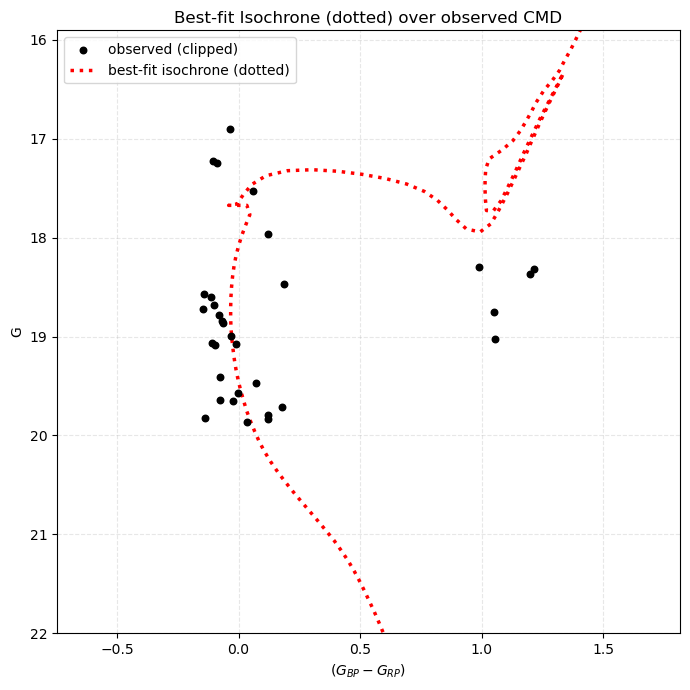

Saved chi2_contour_DM_AG.png


In [9]:
# Fit search ranges and resolutions
Na_grid = 9         # number of ages to sample across available range
Nz_grid = 7         # number of metallicities to sample across available range
NDM = 31            # coarse DM grid size (for optional scanning / debugging)
NAG = 21            # coarse AG grid size
DM_min, DM_max = 18.0, 19.5
AG_min, AG_max = 0.0, 0.836

# resampling resolution along each isochrone
Ns = 240

# photometric floors & model error
sigma_floor_mag = 0.02
sigma_floor_col = 0.01
model_err_mag = 0.01
model_err_col = 0.01

# clipping and minimal stars
n_iter_clip = 1
sigma_clip = 3.0
min_valid = 3

# KDTree visible mag limits
VIS_MIN_MAG = 8.0
VIS_MAX_MAG = 25.0

# contour sampling around best for uncertainties
dm_contour_width = 0.8
ag_contour_width = 0.6
dm_contour_n = 101
ag_contour_n = 101

# Δχ² thresholds (two parameters)
DELTA_CHI2_1SIG_2PARAM = 2.30
DELTA_CHI2_2SIG_2PARAM = 6.17

# ----------------------------
# Utility: pick column heuristically
# ----------------------------
def pick_col(df: pd.DataFrame, candidates: List[str], required: bool = True) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of the candidate columns found: {candidates}")
    return None

# ----------------------------
# 1) Load & clean observations
# ----------------------------
def load_and_clean_obs(path: str) -> Dict[str, np.ndarray]:
    df = pd.read_csv(path)
    col_G = pick_col(df, ['phot_g_mean_mag', 'Gmag', 'V(G)', 'G', 'phot_g', 'V'], required=False)
    col_bp = pick_col(df, ['phot_bp_mean_mag', 'BPmag', 'BP'], required=False)
    col_rp = pick_col(df, ['phot_rp_mean_mag', 'RPmag', 'RP'], required=False)
    col_Gerr = pick_col(df, ['phot_g_mean_mag_error', 'G_ERR', 'Gerr', 'G_ERROR', 'G_err'], required=False)
    col_BPerr = pick_col(df, ['phot_bp_mean_mag_error', 'BP_ERR', 'BPerr', 'BP_ERROR', 'BP_err'], required=False)
    col_RPerr = pick_col(df, ['phot_rp_mean_mag_error', 'RP_ERR', 'RPerr', 'RP_ERROR', 'RP_err'], required=False)

    if col_G is None:
        raise KeyError("Could not find a G magnitude column in your observed file.")

    # compute color if needed
    color_col = None
    for name in ['bp_rp', 'BP-RP', '(BP-RP)', 'phot_bp_mean_mag_minus_phot_rp_mean_mag']:
        if name in df.columns:
            color_col = name
            break
    if color_col is None and col_bp and col_rp:
        df['obs_color'] = df[col_bp] - df[col_rp]
        color_col = 'obs_color'

    if col_Gerr is None:
        df['G_err_fallback'] = sigma_floor_mag
        col_Gerr = 'G_err_fallback'

    if (col_BPerr is None) or (col_RPerr is None):
        if 'color_err' in df.columns:
            df['color_err_use'] = df['color_err']
            col_color_err = 'color_err_use'
        else:
            df['color_err_fallback'] = sigma_floor_col
            col_color_err = 'color_err_fallback'
    else:
        col_color_err = None

    Gmag = df[col_G].to_numpy()
    Gerr = df[col_Gerr].to_numpy()
    if color_col and color_col in df.columns:
        col = df[color_col].to_numpy()
    else:
        col = np.full_like(Gmag, np.nan)

    if col_color_err is None:
        if (col_BPerr in df.columns) and (col_RPerr in df.columns):
            bp_err = df[col_BPerr].to_numpy()
            rp_err = df[col_RPerr].to_numpy()
            col_err = np.sqrt(bp_err**2 + rp_err**2)
        else:
            col_err = np.full_like(Gerr, sigma_floor_col)
    else:
        col_err = df[col_color_err].to_numpy()

    keep = (np.isfinite(Gmag)) & (np.isfinite(Gerr)) & (np.isfinite(col)) & (np.isfinite(col_err))
    Gmag = Gmag[keep]
    Gerr = Gerr[keep]
    col = col[keep]
    col_err = col_err[keep]

    # bright filter
    bright_mask = (Gmag < 20)
    Gmag = Gmag[bright_mask]
    Gerr = Gerr[bright_mask]
    col = col[bright_mask]
    col_err = col_err[bright_mask]
    print(f"Observed stars after cleaning & G < 20 filter: {len(Gmag)}")

    # iterative ridge clipping
    obs_mag = Gmag.copy()
    obs_col = col.copy()
    obs_mag_err = Gerr.copy()
    obs_col_err = col_err.copy()

    for iteration in range(n_iter_clip):
        if len(obs_col) < 10:
            break
        bins = np.arange(np.nanmin(obs_col), np.nanmax(obs_col) + 0.1, 0.1)
        bin_idx = np.digitize(obs_col, bins)
        medG, centers = [], []
        for i in range(1, len(bins)):
            sel = bin_idx == i
            if np.sum(sel) >= 2:
                medG.append(np.median(obs_mag[sel]))
                centers.append(0.5 * (bins[i-1] + bins[i]))
            else:
                medG.append(np.nan)
                centers.append(0.5 * (bins[i-1] + bins[i]))
        medG = np.array(medG)
        centers = np.array(centers)
        good = ~np.isnan(medG)
        if np.sum(good) < 3:
            break
        ridge_func = interp1d(centers[good], medG[good], bounds_error=False, fill_value=np.nan)
        ridge_at_obs = ridge_func(obs_col)
        residuals = obs_mag - ridge_at_obs
        resid_std = np.nanstd(residuals)
        if np.isnan(resid_std) or resid_std == 0:
            break
        mask = np.abs(residuals) <= sigma_clip * resid_std
        obs_mag = obs_mag[mask]
        obs_col = obs_col[mask]
        obs_mag_err = obs_mag_err[mask]
        obs_col_err = obs_col_err[mask]
        print(f"Iteration {iteration+1}: kept {len(obs_mag)} stars after {sigma_clip}σ clipping")

    if len(obs_mag) < min_valid:
        raise RuntimeError("Too few stars after clipping - adjust sigma_clip or check data.")

    return {'mag': obs_mag, 'mag_err': obs_mag_err, 'col': obs_col, 'col_err': obs_col_err}

# ----------------------------
# 2) Load isochrones and resample to s in [0,1]
# ----------------------------
def load_isochrones_with_metadata(folder: str) -> List[Dict[str, Any]]:
    iso_list = []
    for path in sorted(glob.glob(os.path.join(folder, "*.dat"))):
        try:
            data = pd.read_csv(path, sep=r'\s+', comment="#", engine='python')
        except Exception as e:
            print(f"Could not read {path}: {e}")
            continue
        # detect columns
        gcol = None
        for c in ['Gmag', 'G', 'phot_g_mean_mag', 'g_mag']:
            if c in data.columns:
                gcol = c; break
        bpcol = None
        for c in ['G_BPbrmag', 'G_BPmag', 'phot_bp_mean_mag', 'bp_mag']:
            if c in data.columns:
                bpcol = c; break
        rpcol = None
        for c in ['G_RPmag', 'phot_rp_mean_mag', 'rp_mag']:
            if c in data.columns:
                rpcol = c; break
        if (gcol is None) or (bpcol is None) or (rpcol is None):
            # skip
            continue
        data = data.dropna(subset=[gcol, bpcol, rpcol])
        if len(data) < 3:
            continue
        color = (data[bpcol] - data[rpcol]).to_numpy()
        Gmag = data[gcol].to_numpy()
        logAge_val = float(np.unique(data['logAge'])[0]) if 'logAge' in data.columns else np.nan
        Z_val = float(np.unique(data['Z'])[0]) if 'Z' in data.columns else np.nan
        iso_list.append({'file': os.path.basename(path), 'logAge': logAge_val, 'Z': Z_val,
                         'color': color, 'G': Gmag})
    print(f"Loaded {len(iso_list)} isochrones.")
    return iso_list

def resample_isochrones(isochrones: List[Dict[str, Any]], Ns_local: int = 240) -> List[Dict[str, Any]]:
    s_grid = np.linspace(0.0, 1.0, Ns_local)
    resampled = []
    for iso in isochrones:
        color = iso['color']; Gmag = iso['G']
        ok = np.isfinite(color) & np.isfinite(Gmag)
        color = color[ok]; Gmag = Gmag[ok]
        if len(color) < 3:
            continue
        dx = np.diff(color); dy = np.diff(Gmag)
        seglen = np.sqrt(dx*dx + dy*dy)
        cum = np.concatenate(([0.0], np.cumsum(seglen)))
        if cum[-1] == 0:
            cum = np.linspace(0,1,len(color))
        s_orig = cum / cum[-1]
        _, uniq_idx = np.unique(s_orig, return_index=True)
        s_orig_u = s_orig[np.sort(uniq_idx)]
        color_u = color[np.sort(uniq_idx)]
        Gmag_u = Gmag[np.sort(uniq_idx)]
        if len(s_orig_u) < 3:
            continue
        f_col = interp1d(s_orig_u, color_u, kind='linear', bounds_error=False, fill_value='extrapolate')
        f_G = interp1d(s_orig_u, Gmag_u, kind='linear', bounds_error=False, fill_value='extrapolate')
        color_s = f_col(s_grid)
        G_s = f_G(s_grid)
        resampled.append({'file': iso['file'], 'logAge': iso['logAge'], 'Z': iso['Z'],
                          'color_s': color_s, 'G_s': G_s})
    return resampled

# ----------------------------
# 3) Build interpolation cube & RegularGridInterpolators
# ----------------------------
def build_interpolators(resampled: List[Dict[str, Any]]) -> Tuple[RegularGridInterpolator, RegularGridInterpolator, np.ndarray]:
    logAge_vals = np.array(sorted({r['logAge'] for r in resampled if np.isfinite(r['logAge'])}))
    Z_vals = np.array(sorted({r['Z'] for r in resampled if np.isfinite(r['Z'])}))
    if len(logAge_vals) < 1 or len(Z_vals) < 1:
        raise RuntimeError("Insufficient unique ages or Z for interpolation.")
    n_age = len(logAge_vals); n_Z = len(Z_vals)
    Ns_local = len(resampled[0]['color_s'])
    color_cube = np.full((n_age, n_Z, Ns_local), np.nan)
    mag_cube = np.full((n_age, n_Z, Ns_local), np.nan)
    for r in resampled:
        if (not np.isfinite(r['logAge'])) or (not np.isfinite(r['Z'])):
            continue
        ia = int(np.argmin(np.abs(logAge_vals - r['logAge'])))
        iz = int(np.argmin(np.abs(Z_vals - r['Z'])))
        color_cube[ia, iz, :] = r['color_s']
        mag_cube[ia, iz, :] = r['G_s']
    # fill missing by nearest neighbor
    available = []
    for ia in range(n_age):
        for iz in range(n_Z):
            if np.all(np.isfinite(color_cube[ia,iz,:])):
                available.append((logAge_vals[ia], Z_vals[iz], ia, iz))
    if len(available) == 0:
        raise RuntimeError("No complete grid points to fill cube.")
    available = np.array(available)
    ageZ_xy = available[:, :2]
    ia_list = available[:,2].astype(int)
    iz_list = available[:,3].astype(int)
    from scipy.spatial import cKDTree as cKD
    tree = cKD(ageZ_xy)
    for ia in range(n_age):
        for iz in range(n_Z):
            if np.all(np.isfinite(color_cube[ia,iz,:])):
                continue
            query = np.array([logAge_vals[ia], Z_vals[iz]])
            _, nn = tree.query(query, k=1)
            nn = int(nn)
            src_ia = ia_list[nn]; src_iz = iz_list[nn]
            color_cube[ia,iz,:] = color_cube[src_ia, src_iz, :]
            mag_cube[ia,iz,:] = mag_cube[src_ia, src_iz, :]
    s_grid = np.linspace(0.0, 1.0, Ns_local)
    rgi_color = RegularGridInterpolator((logAge_vals, Z_vals, s_grid), color_cube, bounds_error=False, fill_value=None)
    rgi_mag = RegularGridInterpolator((logAge_vals, Z_vals, s_grid), mag_cube, bounds_error=False, fill_value=None)
    return rgi_color, rgi_mag, s_grid

# ----------------------------
# 4) isochrone getter
# ----------------------------
def get_iso_at(age: float, Z: float, rgi_color: RegularGridInterpolator,
               rgi_mag: RegularGridInterpolator, s_grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    Ns_local = len(s_grid)
    pts = np.zeros((Ns_local, 3))
    pts[:,0] = age; pts[:,1] = Z; pts[:,2] = s_grid
    color_interp = rgi_color(pts)
    mag_interp = rgi_mag(pts)
    return color_interp, mag_interp

# ----------------------------
# 5) chi2 for given parameters
# ----------------------------
def chi2_for(age: float, Z: float, DM_val: float, AG_val: float,
             obs: Dict[str, np.ndarray], rgi_color: RegularGridInterpolator,
             rgi_mag: RegularGridInterpolator, s_grid: np.ndarray) -> float:
    # convert AG -> AV -> E(BP-RP)
    AV_val = AG_val / 0.789
    E_val = 0.449 * AV_val
    iso_col_s, iso_mag_s = get_iso_at(age, Z, rgi_color, rgi_mag, s_grid)
    model_col_shifted = iso_col_s + E_val
    model_mag_shifted = iso_mag_s + DM_val + AG_val
    vis_mask = (model_mag_shifted > VIS_MIN_MAG) & (model_mag_shifted < VIS_MAX_MAG)
    if np.sum(vis_mask) < 5:
        return np.inf
    pts_model = np.column_stack([model_col_shifted[vis_mask], model_mag_shifted[vis_mask]])
    tree = cKDTree(pts_model)
    query_pts = np.column_stack([obs['col'], obs['mag']])
    dists, idx = tree.query(query_pts, k=1)
    matched_col = pts_model[:,0][idx]
    matched_mag = pts_model[:,1][idx]
    delta_col = obs['col'] - matched_col
    delta_mag = obs['mag'] - matched_mag
    sig_col = np.sqrt(np.maximum(obs['col_err'], sigma_floor_col)**2 + model_err_col**2)
    sig_mag = np.sqrt(np.maximum(obs['mag_err'], sigma_floor_mag)**2 + model_err_mag**2)
    chi2 = np.sum((delta_col / sig_col)**2) + np.sum((delta_mag / sig_mag)**2)
    return float(chi2)

# ----------------------------
# 6) Grid scan over age/Z with local DM+AG optimization
# ----------------------------
def scan_ageZ(obs: Dict[str, np.ndarray], rgi_color: RegularGridInterpolator, rgi_mag: RegularGridInterpolator, s_grid: np.ndarray) -> Dict[str, Any]:
    age_vals = rgi_color.grid[0]
    Z_vals = rgi_color.grid[1]
    age_grid = np.linspace(age_vals.min(), age_vals.max(), Na_grid)
    Z_grid = np.linspace(Z_vals.min(), Z_vals.max(), Nz_grid)
    results = []
    total = len(age_grid) * len(Z_grid)
    count = 0
    for age_val in age_grid:
        for Z_val in Z_grid:
            count += 1
            x0 = np.array([(DM_min + DM_max)/2.0, (AG_min + AG_max)/2.0])
            bounds = [(DM_min, DM_max), (AG_min, AG_max)]
            def obj(x): return chi2_for(age_val, Z_val, x[0], x[1], obs, rgi_color, rgi_mag, s_grid)
            res = minimize(obj, x0, bounds=bounds, method='L-BFGS-B', options={'ftol':1e-6, 'maxiter':400})
            chi2_val = float(res.fun) if res.success else float(np.inf)
            results.append({'age': float(age_val), 'Z': float(Z_val),
                            'DM_fit': float(res.x[0]), 'AG_fit': float(res.x[1]),
                            'chi2': chi2_val, 'success': bool(res.success)})
            if (count % 5) == 0:
                print(f"Progress {count}/{total}  age={age_val:.3f}, Z={Z_val:.4f}, chi2={chi2_val:.2f}")
    best = min(results, key=lambda r: r['chi2'])
    return {'all': results, 'best': best}

# ----------------------------
# 7) refine best & compute contour uncertainties
# ----------------------------
def refine_and_uncertainties(best_grid: Dict[str, Any], obs: Dict[str, np.ndarray],
                             rgi_color: RegularGridInterpolator, rgi_mag: RegularGridInterpolator, s_grid: np.ndarray) -> Dict[str, Any]:
    age_best = best_grid['age']; Z_best = best_grid['Z']
    x0 = np.array([best_grid['DM_fit'], best_grid['AG_fit']])
    bounds = [(DM_min, DM_max), (AG_min, AG_max)]
    def obj(x): return chi2_for(age_best, Z_best, x[0], x[1], obs, rgi_color, rgi_mag, s_grid)
    res = minimize(obj, x0, bounds=bounds, method='L-BFGS-B', options={'ftol':1e-9, 'maxiter':1000})
    DM_best, AG_best = float(res.x[0]), float(res.x[1])
    chi2_min = float(res.fun)
    # compute chi2 grid
    dm_vals = np.linspace(max(DM_min, DM_best - dm_contour_width), min(DM_max, DM_best + dm_contour_width), dm_contour_n)
    ag_vals = np.linspace(max(AG_min, AG_best - ag_contour_width), min(AG_max, AG_best + ag_contour_width), ag_contour_n)
    DM_grid2, AG_grid2 = np.meshgrid(dm_vals, ag_vals, indexing='xy')
    chi2_grid = np.full(DM_grid2.shape, np.nan)
    for i in range(DM_grid2.shape[0]):
        for j in range(DM_grid2.shape[1]):
            chi2_grid[i,j] = chi2_for(age_best, Z_best, float(DM_grid2[i,j]), float(AG_grid2[i,j]), obs, rgi_color, rgi_mag, s_grid)
    delta_chi2 = chi2_grid - chi2_min
    mask_1sig = (delta_chi2 <= DELTA_CHI2_1SIG_2PARAM) & np.isfinite(delta_chi2)
    if np.any(mask_1sig):
        dm_on = DM_grid2[mask_1sig]; ag_on = AG_grid2[mask_1sig]
        dm_err_low = DM_best - np.min(dm_on); dm_err_high = np.max(dm_on) - DM_best
        ag_err_low = AG_best - np.min(ag_on); ag_err_high = np.max(ag_on) - AG_best
    else:
        dm_err_low = dm_err_high = ag_err_low = ag_err_high = np.nan
    return {
        'age': age_best, 'Z': Z_best,
        'DM_best': DM_best, 'AG_best': AG_best, 'chi2_min': chi2_min,
        'DM_err_low': dm_err_low, 'DM_err_high': dm_err_high,
        'AG_err_low': ag_err_low, 'AG_err_high': ag_err_high,
        'DM_grid2': DM_grid2, 'AG_grid2': AG_grid2, 'delta_chi2': delta_chi2
    }

# ----------------------------
# 8) Main
# ----------------------------
def main():
    obs = load_and_clean_obs(obs_csv)
    isos = load_isochrones_with_metadata(iso_folder)
    if len(isos) == 0:
        raise RuntimeError("No isochrones loaded. Check folder and format.")
    resampled = resample_isochrones(isos, Ns_local=Ns)
    rgi_color, rgi_mag, s_grid = build_interpolators(resampled)
    print("\nStarting coarse scan (age,Z) with DM+AG optimization...")
    scan = scan_ageZ(obs, rgi_color, rgi_mag, s_grid)
    best_grid = scan['best']
    print("Grid best (pre-refine):", best_grid)
    refined = refine_and_uncertainties(best_grid, obs, rgi_color, rgi_mag, s_grid)
    # compute E and A_V
    AV_best = refined['AG_best'] / 0.789
    E_best = 0.449 * AV_best
    # reduced chi2
    n_obs = len(obs['mag'])
    n_params = 4  # age (interpolated), Z (interpolated), DM, AG -> effectively 4 fitted params
    dof = max(n_obs - n_params, 1)
    chi2 = refined['chi2_min']
    chi2_red = chi2 / dof
    # distance
    dist_pc = 10.0 ** ((refined['DM_best'] + 5.0) / 5.0)
    dist_kpc = dist_pc / 1000.0
    # print & save
    out = {
        'logAge': refined['age'],
        'Z': refined['Z'],
        'DM_best': refined['DM_best'],
        'DM_err_low': refined['DM_err_low'],
        'DM_err_high': refined['DM_err_high'],
        'A_G_best': refined['AG_best'],
        'A_G_err_low': refined['AG_err_low'],
        'A_G_err_high': refined['AG_err_high'],
        'E_BP_RP_best': E_best,
        'A_V_best': AV_best,
        'chi2': chi2,
        'chi2_red': chi2_red,
        'dof': dof,
        'distance_pc': float(dist_pc),
        'distance_kpc': float(dist_kpc)
    }
    print("\n=== BEST-FIT SUMMARY ===")
    for k,v in out.items():
        print(f"{k}: {v}")
    pd.Series(out).to_json("bestfit_summary.json", orient="index")
    print("Saved bestfit_summary.json")

    # Plot CMD with best-fit dotted line
    best_col_s, best_mag_s = get_iso_at(refined['age'], refined['Z'], rgi_color, rgi_mag, s_grid)
    # compute shifts
    AV_val = refined['AG_best'] / 0.789
    E_val = 0.449 * AV_val
    best_col_shifted = best_col_s + E_val
    best_mag_shifted = best_mag_s + refined['DM_best'] + refined['AG_best']

    plt.figure(figsize=(7,7))
    plt.scatter(obs['col'], obs['mag'], color='k', s=22, label='observed (clipped)', zorder=5)
    plt.plot(best_col_shifted, best_mag_shifted, linestyle=':', color='red', lw=2.5, label='best-fit isochrone (dotted)')
    plt.gca().invert_yaxis()
    plt.xlim(np.min(obs['col']) - 0.6, np.max(obs['col']) + 0.6)
    plt.ylim(max(22, np.max(obs['mag']) + 1), np.min(obs['mag']) - 1)
    plt.xlabel(r'$(G_{BP}-G_{RP})$'); plt.ylabel('G')
    plt.title('Best-fit Isochrone (dotted) over observed CMD')
    plt.legend()
    plt.grid(ls='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig("bestfit_cmd_with_iso_dotted.png", dpi=200)
    print("Saved bestfit_cmd_with_iso_dotted.png")
    plt.show()

    # Plot chi2 contour
    DM_grid2 = refined['DM_grid2']; AG_grid2 = refined['AG_grid2']; delta_chi2 = refined['delta_chi2']
    plt.figure(figsize=(6.5,5))
    levels = [DELTA_CHI2_1SIG_2PARAM, DELTA_CHI2_2SIG_2PARAM]
    cs = plt.contour(DM_grid2, AG_grid2, delta_chi2, levels=levels, colors=['C1','C2'])
    plt.clabel(cs, inline=True, fontsize=10, fmt={levels[0]:"1σ", levels[1]:"2σ"})
    cf = plt.contourf(DM_grid2, AG_grid2, delta_chi2, levels=50, cmap='viridis', alpha=0.85)
    plt.scatter([refined['DM_best']], [refined['AG_best']], color='red', s=40, label='best')
    plt.xlabel('DM'); plt.ylabel('A_G')
    plt.title('Δχ² (DM vs A_G)')
    plt.colorbar(label=r'$\Delta \chi^2$')
    plt.legend()
    plt.tight_layout()
    plt.savefig("chi2_contour_DM_AG.png", dpi=200)
    print("Saved chi2_contour_DM_AG.png")
    plt.close()

if __name__ == "__main__":
    main()

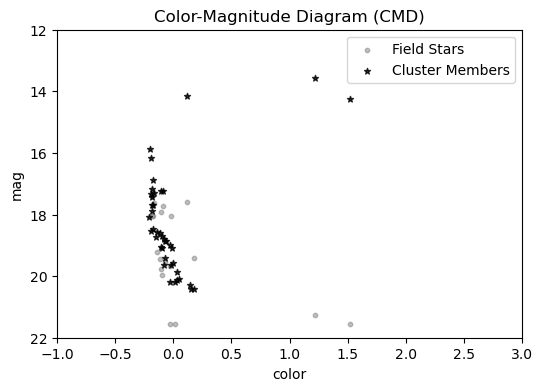

Saved within-cluster stars to:
D:\Research\1.Magellanic-Bridge\project\codes\cluster_parameter_estimation\parameter_estimation\L114_50_within_cluster.csv


In [52]:
# clus_df = pd.read_csv(r'D:\Research\1.Magellanic-Bridge\project\codes\cluster_parameter_estimation\parameter_estimation\L114.csv')

clus_df = pd.read_csv(r'D:\Research\1.Magellanic-Bridge\project\codes\cluster_parameter_estimation\parameter_estimation\L114_50_cleaned.csv')
clus_coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
star_coords = SkyCoord(ra=clus_df['ra'].values*u.deg, dec=clus_df['dec'].values*u.deg, frame='icrs')

separations = clus_coord.separation(star_coords)
clus_df['sep_arcmin'] = separations.arcmin

within_cluster = clus_df[clus_df['sep_arcmin'] <= (0.65)]


# For plotting the CMD of the cluster members and field stars

plt.figure(figsize=(6, 4))
plt.scatter((within_cluster['phot_bp_mean_mag']-within_cluster['phot_rp_mean_mag']), within_cluster['mag_psf'], s=10, c='gray', alpha=0.5, label='Field Stars')
plt.scatter((clus_df['phot_bp_mean_mag'] - clus_df['phot_rp_mean_mag']), clus_df['phot_g_mean_mag'], s=20,  marker = "*", c='black', alpha=0.8, label='Cluster Members')
plt.gca().invert_yaxis()  # Magnitude axis inverted
plt.xlim(-1.0, 3.0) 
plt.ylim(22, 12)
plt.xlabel('color')
plt.ylabel('mag')
plt.title('Color-Magnitude Diagram (CMD)')
plt.legend()
plt.show()

output_csv = r"D:\Research\1.Magellanic-Bridge\project\codes\cluster_parameter_estimation\parameter_estimation\L114_50_within_cluster.csv"
within_cluster.to_csv(output_csv, index=False)

print(f"Saved within-cluster stars to:\n{output_csv}")

In [53]:
obs_csv = pd.read_csv(r'D:\Research\1.Magellanic-Bridge\project\codes\cluster_parameter_estimation\parameter_estimation\L114_50_within_cluster.csv')

print(obs_csv.columns)

Index(['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_g_mean_mag_error',
       'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error', 'xcen', 'ycen',
       'mag_psf', 'merr_psf', 'sharp_psf', 'density', 'sep_arcmin'],
      dtype='object')


In [54]:
#!/usr/bin/env python3
"""
Isochrone fitting with robust cleaning and perpendicular-distance isochrone clipping.
Designed to reproduce MS-cleaning behavior similar to the example figure.
Edit `obs_csv` and `iso_folder` paths below.
"""

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple
from scipy.interpolate import interp1d, RegularGridInterpolator
from scipy.optimize import minimize
from scipy.spatial import cKDTree

# ----------------------------
# Fitting & resampling parameters
# ----------------------------
Na_grid = 9
Nz_grid = 7
Ns = 240

DM_min, DM_max = 18.0, 19.5
AG_min, AG_max = 0.0, 0.836

# photometric floors & model error
sigma_floor_mag = 0.02
sigma_floor_col = 0.01
model_err_mag = 0.01
model_err_col = 0.01

# kd/isoclip params
kd_k_nn = 6
kd_n_sigma = 3.0
iso_asymmetric = (3.0, 5.0)   # (fainter_side_sigma, brighter_side_sigma)
iso_iterate = 2
iso_n_sigma = 3.0

# minimal stars
min_valid = 3

# visibility
VIS_MIN_MAG = 8.0
VIS_MAX_MAG = 25.0

# contour sampling
dm_contour_width = 0.8
ag_contour_width = 0.6
dm_contour_n = 101
ag_contour_n = 101

# Δχ² thresholds (two parameters)
DELTA_CHI2_1SIG_2PARAM = 2.30
DELTA_CHI2_2SIG_2PARAM = 6.17

# ----------------------------
# utilities
# ----------------------------
def pick_col(df: pd.DataFrame, candidates: List[str], required: bool = True) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of the candidate columns found: {candidates}")
    return None

# ----------------------------
# perpendicular distance utilities (to isochrone polyline)
# ----------------------------
def proj_point_to_segment(px, py, x0, y0, x1, y1):
    """
    Project point P(px,py) to segment (x0,y0)-(x1,y1).
    Returns (t, x_proj, y_proj, sq_dist) where t in [0,1] is projection parameter along segment.
    """
    vx = x1 - x0
    vy = y1 - y0
    wx = px - x0
    wy = py - y0
    denom = vx*vx + vy*vy
    if denom == 0:
        return 0.0, x0, y0, (px-x0)**2 + (py-y0)**2
    t = (wx*vx + wy*vy) / denom
    if t <= 0:
        x_proj, y_proj = x0, y0
    elif t >= 1:
        x_proj, y_proj = x1, y1
    else:
        x_proj = x0 + t*vx
        y_proj = y0 + t*vy
    sqd = (px - x_proj)**2 + (py - y_proj)**2
    return t, x_proj, y_proj, sqd

def distances_to_iso_perp(obs_col, obs_mag, iso_col, iso_mag, color_scale=0.2, mag_scale=0.5):
    """
    Compute perpendicular distances from each observed (color,mag) to the isochrone polyline
    after rescaling axes so both color and mag contribute similarly.
    color_scale, mag_scale are typical scales (in magnitudes) used to normalize.
    Returns:
      dists (array length n_obs) - Euclidean distances in the rescaled space
      proj_cols, proj_mags - projected isochrone points (in original units)
      seg_idx - index of segment for each obs
    """
    # scale iso and obs coordinates
    c_iso = np.array(iso_col)
    m_iso = np.array(iso_mag)
    # rescale to balanced units
    cs = color_scale
    ms = mag_scale
    iso_x = c_iso / cs
    iso_y = m_iso / ms
    obs_x = obs_col / cs
    obs_y = obs_mag / ms

    n_obs = len(obs_x)
    n_seg = len(iso_x) - 1
    dists = np.full(n_obs, np.inf)
    proj_cols = np.full(n_obs, np.nan)
    proj_mags = np.full(n_obs, np.nan)
    seg_idx = np.full(n_obs, -1, dtype=int)

    # For speed, build a KDTree of segment midpoints to find candidate segments
    mid_x = 0.5 * (iso_x[:-1] + iso_x[1:])
    mid_y = 0.5 * (iso_y[:-1] + iso_y[1:])
    seg_mid_tree = cKDTree(np.column_stack([mid_x, mid_y]))

    # For each point, query nearby segments (within some radius)
    # radius set to median segment length * 3 (in scaled units)
    seg_lens = np.sqrt((iso_x[1:]-iso_x[:-1])**2 + (iso_y[1:]-iso_y[:-1])**2)
    if len(seg_lens) == 0:
        return dists, proj_cols, proj_mags, seg_idx
    radius = max(np.median(seg_lens)*3.0, np.max(seg_lens)*3.0)
    # but to avoid very large radius, clamp
    radius = max(radius, 0.1)

    for i in range(n_obs):
        # candidate segments via midpoint KDTree
        xi, yi = obs_x[i], obs_y[i]
        # find all segments (or at least nearest few)
        ksearch = min(12, len(mid_x))
        dmid, ids = seg_mid_tree.query([xi, yi], k=ksearch)
        if np.isscalar(ids):
            ids = np.array([ids])
        best_sqd = np.inf
        best_proj = (np.nan, np.nan)
        best_seg = -1
        # test candidate segments
        for seg in ids:
            x0, y0 = iso_x[seg], iso_y[seg]
            x1, y1 = iso_x[seg+1], iso_y[seg+1]
            _, xpj, ypj, sqd = proj_point_to_segment(xi, yi, x0, y0, x1, y1)
            if sqd < best_sqd:
                best_sqd = sqd
                best_proj = (xpj, ypj)
                best_seg = seg
        # save best (rescale back to original)
        dists[i] = np.sqrt(best_sqd)
        proj_cols[i] = best_proj[0] * cs
        proj_mags[i] = best_proj[1] * ms
        seg_idx[i] = best_seg
    return dists, proj_cols, proj_mags, seg_idx

# ----------------------------
# KDTree 2D local-density clipping (helper)
# ----------------------------
def kd2d_clip(obs_col: np.ndarray, obs_mag: np.ndarray, k_nn: int = 6, n_sigma: float = 3.0,
              use_robust: bool = True, verbose: bool = True) -> Tuple[np.ndarray, np.ndarray, float]:
    pts = np.column_stack([obs_col, obs_mag])
    if len(pts) == 0:
        return np.zeros_like(obs_col, dtype=bool), np.array([]), np.nan
    k = min(max(2, k_nn), len(pts))
    dists, ids = cKDTree(pts).query(pts, k=k)
    use_dist = dists[:, 1] if k > 1 else dists[:, 0]
    if use_robust:
        mad = np.median(np.abs(use_dist - np.median(use_dist)))
        sigma = 1.4826 * mad if mad > 0 else np.std(use_dist)
    else:
        sigma = np.std(use_dist)
    mask = use_dist <= (n_sigma * sigma)
    if verbose:
        print(f"[KD2D] kept {mask.sum()} / {len(obs_col)} (σ={sigma:.4f}, k_nn={k})")
    return mask, use_dist, sigma

# ----------------------------
# isochrone clipping but using perpendicular distances
# ----------------------------
def isochrone_clip_perp(obs_col: np.ndarray, obs_mag: np.ndarray,
                        iso_col: np.ndarray, iso_mag: np.ndarray,
                        color_scale=0.2, mag_scale=0.5,
                        n_sigma: float = 3.0, use_robust: bool = True,
                        asymmetric: Tuple[float, float] = (3.0,5.0),
                        iterate: int = 2, verbose: bool = True) -> Tuple[np.ndarray, np.ndarray, float]:
    n_obs = len(obs_col)
    mask = np.ones(n_obs, dtype=bool)
    last_sigma = np.nan
    for it in range(iterate):
        idx_mask = np.where(mask)[0]
        if len(idx_mask) == 0:
            break
        dists, proj_cols, proj_mags, seg_idx = distances_to_iso_perp(
            obs_col[idx_mask], obs_mag[idx_mask], iso_col, iso_mag,
            color_scale=color_scale, mag_scale=mag_scale
        )
        # robust sigma of distances
        if use_robust:
            mad = np.median(np.abs(dists - np.median(dists)))
            sigma = 1.4826 * mad if mad > 0 else np.std(dists)
        else:
            sigma = np.std(dists)
        # compute signed residual along magnitude to allow asymmetric clipping
        # resid_mag = obs_mag - proj_mag (positive if observed is fainter)
        resid_mag = obs_mag[idx_mask] - proj_mags
        sigma_up, sigma_down = asymmetric
        keep_local = (resid_mag <= sigma_up * sigma) & (resid_mag >= -sigma_down * sigma)
        new_mask = mask.copy()
        remove_idx = idx_mask[~keep_local]
        if len(remove_idx) > 0:
            new_mask[remove_idx] = False
        mask = new_mask
        last_sigma = sigma
        if verbose:
            print(f"[ISO-PERP] iter {it+1}/{iterate}: kept {mask.sum()} / {n_obs} (σ={sigma:.4f})")
        if mask.sum() < min_valid:
            print("[ISO-PERP] Too few stars remain after clipping; stopping early.")
            break
    # final distances for all stars
    final_dists, final_pc, final_pm, final_seg = distances_to_iso_perp(obs_col, obs_mag, iso_col, iso_mag, color_scale=color_scale, mag_scale=mag_scale)
    return mask, final_dists, last_sigma

# ----------------------------
# 1) Load & initial cleaning
# ----------------------------
def load_and_clean_obs(path: str) -> Dict[str, np.ndarray]:
    df = pd.read_csv(path)
    col_G = pick_col(df, ['phot_g_mean_mag', 'Gmag', 'V(G)', 'G', 'phot_g', 'V'], required=False)
    col_bp = pick_col(df, ['phot_bp_mean_mag', 'BPmag', 'BP'], required=False)
    col_rp = pick_col(df, ['phot_rp_mean_mag', 'RPmag', 'RP'], required=False)
    col_Gerr = pick_col(df, ['phot_g_mean_mag_error', 'G_ERR', 'Gerr', 'G_ERROR', 'G_err'], required=False)
    col_BPerr = pick_col(df, ['phot_bp_mean_mag_error', 'BP_ERR', 'BPerr', 'BP_ERROR', 'BP_err'], required=False)
    col_RPerr = pick_col(df, ['phot_rp_mean_mag_error', 'RP_ERR', 'RPerr', 'RP_ERROR', 'RP_err'], required=False)

    if col_G is None:
        raise KeyError("Could not find a G magnitude column in your observed file.")

    # compute color if needed
    color_col = None
    for name in ['bp_rp', 'BP-RP', '(BP-RP)', 'phot_bp_mean_mag_minus_phot_rp_mean_mag', 'BP-RP']:
        if name in df.columns:
            color_col = name
            break
    if color_col is None and col_bp and col_rp:
        df['obs_color'] = df[col_bp] - df[col_rp]
        color_col = 'obs_color'

    if col_Gerr is None:
        df['G_err_fallback'] = sigma_floor_mag
        col_Gerr = 'G_err_fallback'

    if (col_BPerr is None) or (col_RPerr is None):
        if 'color_err' in df.columns:
            df['color_err_use'] = df['color_err']
            col_color_err = 'color_err_use'
        else:
            df['color_err_fallback'] = sigma_floor_col
            col_color_err = 'color_err_fallback'
    else:
        col_color_err = None

    Gmag = df[col_G].to_numpy()
    Gerr = df[col_Gerr].to_numpy()
    if color_col and color_col in df.columns:
        col = df[color_col].to_numpy()
    else:
        col = np.full_like(Gmag, np.nan)

    if col_color_err is None:
        if (col_BPerr in df.columns) and (col_RPerr in df.columns):
            bp_err = df[col_BPerr].to_numpy()
            rp_err = df[col_RPerr].to_numpy()
            col_err = np.sqrt(bp_err**2 + rp_err**2)
        else:
            col_err = np.full_like(Gerr, sigma_floor_col)
    else:
        col_err = df[col_color_err].to_numpy()

    keep = (np.isfinite(Gmag)) & (np.isfinite(Gerr)) & (np.isfinite(col)) & (np.isfinite(col_err))
    Gmag = Gmag[keep]
    Gerr = Gerr[keep]
    col = col[keep]
    col_err = col_err[keep]

    # bright filter (G < 20)
    bright_mask = (Gmag < 20)
    Gmag = Gmag[bright_mask]
    Gerr = Gerr[bright_mask]
    col = col[bright_mask]
    col_err = col_err[bright_mask]
    print(f"Observed stars after cleaning & G < 20 filter: {len(Gmag)}")

    return {'mag': Gmag, 'mag_err': Gerr, 'col': col, 'col_err': col_err}

# ----------------------------
# 2) isochrone loading & resampling (unchanged)
# ----------------------------
def load_isochrones_with_metadata(folder: str) -> List[Dict[str, Any]]:
    iso_list = []
    for path in sorted(glob.glob(os.path.join(folder, "*.dat"))):
        try:
            data = pd.read_csv(path, sep=r'\s+', comment="#", engine='python')
        except Exception as e:
            print(f"Could not read {path}: {e}")
            continue
        gcol = None
        for c in ['Gmag', 'G', 'phot_g_mean_mag', 'g_mag']:
            if c in data.columns:
                gcol = c; break
        bpcol = None
        for c in ['G_BPbrmag', 'G_BPmag', 'phot_bp_mean_mag', 'bp_mag']:
            if c in data.columns:
                bpcol = c; break
        rpcol = None
        for c in ['G_RPmag', 'phot_rp_mean_mag', 'rp_mag']:
            if c in data.columns:
                rpcol = c; break
        if (gcol is None) or (bpcol is None) or (rpcol is None):
            continue
        data = data.dropna(subset=[gcol, bpcol, rpcol])
        if len(data) < 3:
            continue
        color = (data[bpcol] - data[rpcol]).to_numpy()
        Gmag = data[gcol].to_numpy()
        logAge_val = float(np.unique(data['logAge'])[0]) if 'logAge' in data.columns else np.nan
        Z_val = float(np.unique(data['Z'])[0]) if 'Z' in data.columns else np.nan
        iso_list.append({'file': os.path.basename(path), 'logAge': logAge_val, 'Z': Z_val,
                         'color': color, 'G': Gmag})
    print(f"Loaded {len(iso_list)} isochrones.")
    return iso_list

def resample_isochrones(isochrones: List[Dict[str, Any]], Ns_local: int = 240) -> List[Dict[str, Any]]:
    s_grid = np.linspace(0.0, 1.0, Ns_local)
    resampled = []
    for iso in isochrones:
        color = iso['color']; Gmag = iso['G']
        ok = np.isfinite(color) & np.isfinite(Gmag)
        color = color[ok]; Gmag = Gmag[ok]
        if len(color) < 3:
            continue
        dx = np.diff(color); dy = np.diff(Gmag)
        seglen = np.sqrt(dx*dx + dy*dy)
        cum = np.concatenate(([0.0], np.cumsum(seglen)))
        if cum[-1] == 0:
            cum = np.linspace(0,1,len(color))
        s_orig = cum / cum[-1]
        _, uniq_idx = np.unique(s_orig, return_index=True)
        s_orig_u = s_orig[np.sort(uniq_idx)]
        color_u = color[np.sort(uniq_idx)]
        Gmag_u = Gmag[np.sort(uniq_idx)]
        if len(s_orig_u) < 3:
            continue
        f_col = interp1d(s_orig_u, color_u, kind='linear', bounds_error=False, fill_value='extrapolate')
        f_G = interp1d(s_orig_u, Gmag_u, kind='linear', bounds_error=False, fill_value='extrapolate')
        color_s = f_col(s_grid)
        G_s = f_G(s_grid)
        resampled.append({'file': iso['file'], 'logAge': iso['logAge'], 'Z': iso['Z'],
                          'color_s': color_s, 'G_s': G_s})
    return resampled

# ----------------------------
# 3) Build interpolation cube
# ----------------------------
def build_interpolators(resampled: List[Dict[str, Any]]) -> Tuple[RegularGridInterpolator, RegularGridInterpolator, np.ndarray]:
    logAge_vals = np.array(sorted({r['logAge'] for r in resampled if np.isfinite(r['logAge'])}))
    Z_vals = np.array(sorted({r['Z'] for r in resampled if np.isfinite(r['Z'])}))
    if len(logAge_vals) < 1 or len(Z_vals) < 1:
        raise RuntimeError("Insufficient unique ages or Z for interpolation.")
    n_age = len(logAge_vals); n_Z = len(Z_vals)
    Ns_local = len(resampled[0]['color_s'])
    color_cube = np.full((n_age, n_Z, Ns_local), np.nan)
    mag_cube = np.full((n_age, n_Z, Ns_local), np.nan)
    for r in resampled:
        if (not np.isfinite(r['logAge'])) or (not np.isfinite(r['Z'])):
            continue
        ia = int(np.argmin(np.abs(logAge_vals - r['logAge'])))
        iz = int(np.argmin(np.abs(Z_vals - r['Z'])))
        color_cube[ia, iz, :] = r['color_s']
        mag_cube[ia, iz, :] = r['G_s']
    # fill missing by nearest neighbor
    available = []
    for ia in range(n_age):
        for iz in range(n_Z):
            if np.all(np.isfinite(color_cube[ia,iz,:])):
                available.append((logAge_vals[ia], Z_vals[iz], ia, iz))
    if len(available) == 0:
        raise RuntimeError("No complete grid points to fill cube.")
    available = np.array(available)
    ageZ_xy = available[:, :2]
    ia_list = available[:,2].astype(int)
    iz_list = available[:,3].astype(int)
    tree = cKDTree(ageZ_xy)
    for ia in range(n_age):
        for iz in range(n_Z):
            if np.all(np.isfinite(color_cube[ia,iz,:])):
                continue
            query = np.array([logAge_vals[ia], Z_vals[iz]])
            _, nn = tree.query(query, k=1)
            nn = int(nn)
            src_ia = ia_list[nn]; src_iz = iz_list[nn]
            color_cube[ia,iz,:] = color_cube[src_ia, src_iz, :]
            mag_cube[ia,iz,:] = mag_cube[src_ia, src_iz, :]
    s_grid = np.linspace(0.0, 1.0, Ns_local)
    rgi_color = RegularGridInterpolator((logAge_vals, Z_vals, s_grid), color_cube, bounds_error=False, fill_value=None)
    rgi_mag = RegularGridInterpolator((logAge_vals, Z_vals, s_grid), mag_cube, bounds_error=False, fill_value=None)
    return rgi_color, rgi_mag, s_grid

# ----------------------------
# 4) get isochrone
# ----------------------------
def get_iso_at(age: float, Z: float, rgi_color: RegularGridInterpolator,
               rgi_mag: RegularGridInterpolator, s_grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    Ns_local = len(s_grid)
    pts = np.zeros((Ns_local, 3))
    pts[:,0] = age; pts[:,1] = Z; pts[:,2] = s_grid
    color_interp = rgi_color(pts)
    mag_interp = rgi_mag(pts)
    return color_interp, mag_interp

# ----------------------------
# 5) chi2 using perpendicular projection matching
# ----------------------------
def chi2_for(age: float, Z: float, DM_val: float, AG_val: float,
             obs: Dict[str, np.ndarray], rgi_color: RegularGridInterpolator,
             rgi_mag: RegularGridInterpolator, s_grid: np.ndarray,
             color_scale=0.2, mag_scale=0.5) -> float:
    # convert AG -> AV -> E(BP-RP)
    AV_val = AG_val / 0.789
    E_val = 0.449 * AV_val
    iso_col_s, iso_mag_s = get_iso_at(age, Z, rgi_color, rgi_mag, s_grid)
    model_col_shifted = iso_col_s + E_val
    model_mag_shifted = iso_mag_s + DM_val + AG_val
    vis_mask = (model_mag_shifted > VIS_MIN_MAG) & (model_mag_shifted < VIS_MAX_MAG)
    if np.sum(vis_mask) < 5:
        return np.inf
    mc = model_col_shifted[vis_mask]; mm = model_mag_shifted[vis_mask]
    # find perpendicular distances and projected points
    dists, proj_cols, proj_mags, seg_idx = distances_to_iso_perp(obs['col'], obs['mag'], mc, mm,
                                                                 color_scale=color_scale, mag_scale=mag_scale)
    # matched deltas
    delta_col = obs['col'] - proj_cols
    delta_mag = obs['mag'] - proj_mags
    # per-star uncertainties
    sig_col = np.sqrt(np.maximum(obs['col_err'], sigma_floor_col)**2 + model_err_col**2)
    sig_mag = np.sqrt(np.maximum(obs['mag_err'], sigma_floor_mag)**2 + model_err_mag**2)
    # chi2: sum of (delta/sigma)^2 for both axes
    chi2 = np.sum((delta_col / sig_col)**2 + (delta_mag / sig_mag)**2)
    return float(chi2)

# ----------------------------
# 6) grid scan (coarse)
# ----------------------------
def scan_ageZ(obs: Dict[str, np.ndarray], rgi_color: RegularGridInterpolator, rgi_mag: RegularGridInterpolator, s_grid: np.ndarray) -> Dict[str, Any]:
    age_vals = rgi_color.grid[0]
    Z_vals = rgi_color.grid[1]
    age_grid = np.linspace(age_vals.min(), age_vals.max(), Na_grid)
    Z_grid = np.linspace(Z_vals.min(), Z_vals.max(), Nz_grid)
    results = []
    total = len(age_grid) * len(Z_grid)
    count = 0
    for age_val in age_grid:
        for Z_val in Z_grid:
            count += 1
            x0 = np.array([(DM_min + DM_max)/2.0, (AG_min + AG_max)/2.0])
            bounds = [(DM_min, DM_max), (AG_min, AG_max)]
            def obj(x): return chi2_for(age_val, Z_val, x[0], x[1], obs, rgi_color, rgi_mag, s_grid)
            res = minimize(obj, x0, bounds=bounds, method='L-BFGS-B', options={'ftol':1e-6, 'maxiter':400})
            chi2_val = float(res.fun) if res.success else float(np.inf)
            results.append({'age': float(age_val), 'Z': float(Z_val),
                            'DM_fit': float(res.x[0]), 'AG_fit': float(res.x[1]),
                            'chi2': chi2_val, 'success': bool(res.success)})
            if (count % 5) == 0:
                print(f"Progress {count}/{total}  age={age_val:.3f}, Z={Z_val:.4f}, chi2={chi2_val:.2f}")
    best = min(results, key=lambda r: r['chi2'])
    return {'all': results, 'best': best}

# ----------------------------
# 7) refine & uncertainties (unchanged)
# ----------------------------
def refine_and_uncertainties(best_grid: Dict[str, Any], obs: Dict[str, np.ndarray],
                             rgi_color: RegularGridInterpolator, rgi_mag: RegularGridInterpolator, s_grid: np.ndarray) -> Dict[str, Any]:
    age_best = best_grid['age']; Z_best = best_grid['Z']
    x0 = np.array([best_grid['DM_fit'], best_grid['AG_fit']])
    bounds = [(DM_min, DM_max), (AG_min, AG_max)]
    def obj(x): return chi2_for(age_best, Z_best, x[0], x[1], obs, rgi_color, rgi_mag, s_grid)
    res = minimize(obj, x0, bounds=bounds, method='L-BFGS-B', options={'ftol':1e-9, 'maxiter':1000})
    DM_best, AG_best = float(res.x[0]), float(res.x[1])
    chi2_min = float(res.fun)
    # compute chi2 grid
    dm_vals = np.linspace(max(DM_min, DM_best - dm_contour_width), min(DM_max, DM_best + dm_contour_width), dm_contour_n)
    ag_vals = np.linspace(max(AG_min, AG_best - ag_contour_width), min(AG_max, AG_best + ag_contour_width), ag_contour_n)
    DM_grid2, AG_grid2 = np.meshgrid(dm_vals, ag_vals, indexing='xy')
    chi2_grid = np.full(DM_grid2.shape, np.nan)
    for i in range(DM_grid2.shape[0]):
        for j in range(DM_grid2.shape[1]):
            chi2_grid[i,j] = chi2_for(age_best, Z_best, float(DM_grid2[i,j]), float(AG_grid2[i,j]), obs, rgi_color, rgi_mag, s_grid)
    delta_chi2 = chi2_grid - chi2_min
    mask_1sig = (delta_chi2 <= DELTA_CHI2_1SIG_2PARAM) & np.isfinite(delta_chi2)
    if np.any(mask_1sig):
        dm_on = DM_grid2[mask_1sig]; ag_on = AG_grid2[mask_1sig]
        dm_err_low = DM_best - np.min(dm_on); dm_err_high = np.max(dm_on) - DM_best
        ag_err_low = AG_best - np.min(ag_on); ag_err_high = np.max(ag_on) - AG_best
    else:
        dm_err_low = dm_err_high = ag_err_low = ag_err_high = np.nan
    return {
        'age': age_best, 'Z': Z_best,
        'DM_best': DM_best, 'AG_best': AG_best, 'chi2_min': chi2_min,
        'DM_err_low': dm_err_low, 'DM_err_high': dm_err_high,
        'AG_err_low': ag_err_low, 'AG_err_high': ag_err_high,
        'DM_grid2': DM_grid2, 'AG_grid2': AG_grid2, 'delta_chi2': delta_chi2
    }

# ----------------------------
# 8) Main pipeline
# ----------------------------
def main():
    obs = load_and_clean_obs(obs_csv)   # base cleaning
    # Remove red field sequence before fitting (BP-RP > 0.8)
    colormask = obs['col'] < 0.8
    obs = {k: v[colormask] for k, v in obs.items()}
    print(f"After color cut (BP-RP < 0.8): {len(obs['mag'])} stars")

    isos = load_isochrones_with_metadata(iso_folder)
    if len(isos) == 0:
        raise RuntimeError("No isochrones loaded. Check folder and format.")
    resampled = resample_isochrones(isos, Ns_local=Ns)
    rgi_color, rgi_mag, s_grid = build_interpolators(resampled)

    # --- FIRST coarse scan restricted to MS (use color range -0.5..0.5) to get robust initial guess
    ms_mask = (obs['col'] > -0.5) & (obs['col'] < 0.5)
    obs_ms = {k: v[ms_mask] for k, v in obs.items()}
    print(f"MS-first subset used for initial fit: {len(obs_ms['mag'])} stars")

    print("\nStarting coarse scan (initial, MS-only) ...")
    scan_init = scan_ageZ(obs_ms, rgi_color, rgi_mag, s_grid)
    best_init = scan_init['best']
    print("Initial coarse best:", best_init)

    # Build preliminary shifted isochrone using initial fit
    iso_col_s, iso_mag_s = get_iso_at(best_init['age'], best_init['Z'], rgi_color, rgi_mag, s_grid)
    DM0 = best_init['DM_fit']; AG0 = best_init['AG_fit']
    AV0 = AG0 / 0.789; E0 = 0.449 * AV0
    iso_col_shifted = iso_col_s + E0
    iso_mag_shifted = iso_mag_s + DM0 + AG0

    # KDTree gross outlier removal on full color-cut sample
    mask_kd, kd_dists, kd_sigma = kd2d_clip(obs['col'], obs['mag'], k_nn=kd_k_nn, n_sigma=kd_n_sigma, use_robust=True)
    obs_kd = {k: v[mask_kd] for k, v in obs.items()}
    print(f"After KDTree: {len(obs_kd['mag'])} stars")

    # Isochrone perpendicular clipping using the preliminary shifted iso
    mask_iso, iso_dists, iso_sigma = isochrone_clip_perp(
        obs_kd['col'], obs_kd['mag'],
        iso_col_shifted, iso_mag_shifted,
        color_scale=0.2, mag_scale=0.5,
        n_sigma=iso_n_sigma, use_robust=True,
        asymmetric=iso_asymmetric, iterate=iso_iterate, verbose=True
    )
    obs_clean = {k: v[mask_iso] for k, v in obs_kd.items()}
    print(f"After isochrone perpendicular clipping: {len(obs_clean['mag'])} stars")

    # Diagnostic plot before/after
    try:
        plt.figure(figsize=(7,7))
        plt.scatter(obs['col'], obs['mag'], s=18, alpha=0.25, label='original (color-cut)')
        plt.scatter(obs_clean['col'], obs_clean['mag'], s=40, color='k', label='cleaned')
        plt.plot(iso_col_shifted, iso_mag_shifted, linestyle=':', color='red', lw=2.5, label='init isochrone')
        plt.gca().invert_yaxis()
        plt.xlabel(r'$(G_{BP}-G_{RP})$'); plt.ylabel('G')
        plt.legend(); plt.title('CMD: before / after cleaning')
        plt.tight_layout()
        plt.savefig("cmd_before_after_cleaning_perp.png", dpi=200)
        plt.close()
        print("Saved cmd_before_after_cleaning_perp.png")
    except Exception as e:
        print("Diag plot failed:", e)

    # Re-run coarse scan on cleaned CMD (full color range used earlier but cleaned)
    print("\nRe-running coarse scan on cleaned CMD ...")
    scan2 = scan_ageZ(obs_clean, rgi_color, rgi_mag, s_grid)
    best_grid2 = scan2['best']
    print("Grid best (after cleaning):", best_grid2)

    refined = refine_and_uncertainties(best_grid2, obs_clean, rgi_color, rgi_mag, s_grid)

    # compute derived quantities
    AV_best = refined['AG_best'] / 0.789
    E_best = 0.449 * AV_best
    n_obs = len(obs_clean['mag'])
    n_params = 4
    dof = max(n_obs - n_params, 1)
    chi2 = refined['chi2_min']
    chi2_red = chi2 / dof
    dist_pc = 10.0 ** ((refined['DM_best'] + 5.0) / 5.0)
    dist_kpc = dist_pc / 1000.0

    out = {
        'logAge': refined['age'],
        'Z': refined['Z'],
        'DM_best': refined['DM_best'],
        'DM_err_low': refined['DM_err_low'],
        'DM_err_high': refined['DM_err_high'],
        'A_G_best': refined['AG_best'],
        'A_G_err_low': refined['AG_err_low'],
        'A_G_err_high': refined['AG_err_high'],
        'E_BP_RP_best': E_best,
        'A_V_best': AV_best,
        'chi2': chi2,
        'chi2_red': chi2_red,
        'dof': dof,
        'distance_pc': float(dist_pc),
        'distance_kpc': float(dist_kpc)
    }
    print("\n=== BEST-FIT SUMMARY ===")
    for k,v in out.items():
        print(f"{k}: {v}")
    pd.Series(out).to_json("bestfit_summary_perp.json", orient="index")
    print("Saved bestfit_summary_perp.json")

    # Plot final best-fit isochrone on cleaned CMD
    best_col_s, best_mag_s = get_iso_at(refined['age'], refined['Z'], rgi_color, rgi_mag, s_grid)
    AV_val = refined['AG_best'] / 0.789
    E_val = 0.449 * AV_val
    best_col_shifted = best_col_s + E_val
    best_mag_shifted = best_mag_s + refined['DM_best'] + refined['AG_best']

    plt.figure(figsize=(7,7))
    plt.scatter(obs_clean['col'], obs_clean['mag'], color='k', s=36, label='observed (cleaned)')
    plt.plot(best_col_shifted, best_mag_shifted, linestyle=':', color='red', lw=2.5, label='best-fit isochrone (dotted)')
    plt.gca().invert_yaxis()
    plt.xlim(np.min(obs_clean['col']) - 0.6, np.max(obs_clean['col']) + 0.6)
    plt.ylim(max(22, np.max(obs_clean['mag']) + 1), np.min(obs_clean['mag']) - 1)
    plt.xlabel(r'$(G_{BP}-G_{RP})$'); plt.ylabel('G')
    plt.title('Best-fit Isochrone (dotted) over cleaned CMD (perp clip)')
    plt.legend()
    plt.grid(ls='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig("bestfit_cmd_with_iso_perp.png", dpi=200)
    print("Saved bestfit_cmd_with_iso_perp.png")
    plt.show()

    # χ² contour (DM vs AG)
    DM_grid2 = refined['DM_grid2']; AG_grid2 = refined['AG_grid2']; delta_chi2 = refined['delta_chi2']
    plt.figure(figsize=(6.5,5))
    levels = [DELTA_CHI2_1SIG_2PARAM, DELTA_CHI2_2SIG_2PARAM]
    cs = plt.contour(DM_grid2, AG_grid2, delta_chi2, levels=levels, colors=['C1','C2'])
    plt.clabel(cs, inline=True, fontsize=10, fmt={levels[0]:"1σ", levels[1]:"2σ"})
    cf = plt.contourf(DM_grid2, AG_grid2, delta_chi2, levels=50, cmap='viridis', alpha=0.85)
    plt.scatter([refined['DM_best']], [refined['AG_best']], color='red', s=40, label='best')
    plt.xlabel('DM'); plt.ylabel('A_G')
    plt.title('Δχ² (DM vs A_G)')
    plt.colorbar(label=r'$\Delta \chi^2$')
    plt.legend()
    plt.tight_layout()
    plt.savefig("chi2_contour_DM_AG_perp.png", dpi=200)
    print("Saved chi2_contour_DM_AG_perp.png")
    plt.close()

if __name__ == "__main__":
    main() 

TypeError: argument of type 'method' is not iterable

In [ ]:
#!/usr/bin/env python3
"""
fit_iso_after_clipped_gaia.py

Full parameter estimation (χ²) using Gaia G vs (BP-RP) after you've done 1.5σ clipping.
- Loads cleaned observed file (Gaia columns)
- Loads PARSEC-like isochrones (*.dat) with columns: logAge, Zini, Gmag, G_BPmag, G_RPmag
- Resamples isochrones, builds interpolation cube (fills missing cells)
- Coarse scan in (age, Z) + refine DM & A_G
- Computes DM, A_G, A_V, E(BP-RP), distance, chi2, chi2_red, dof
- Saves bestfit_parameters.json and diagnostic PNGs
"""

import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Any, Tuple
from scipy.interpolate import interp1d, RegularGridInterpolator
from scipy.optimize import minimize
from scipy.spatial import cKDTree

# ----------------------------
# USER PATHS (edit if needed)
# ----------------------------
iso_folder  =   r'D:\Research\1.Magellanic-Bridge\project\codes\SMC2_analysis\iso_DR'                     # folder containing all .dat isochrone files
obs_file    =r'D:\Research\1.Magellanic-Bridge\project\codes\cluster_parameter_estimation\parameter_estimation\L114_50_within_cluster.csv'   # cleaned observed CSV (after your 1.5σ clipping)

# ----------------------------
# PARAMETERS (tweak if desired)
# ----------------------------
Ns = 240           # resample points along each isochrone
Na_grid = 9        # coarse number of ages to sample in scan
Nz_grid = 7        # coarse number of metallicities to sample in scan

DM_min, DM_max = 18.0, 19.5
AG_min, AG_max = 0.0, 0.836

VIS_MIN_MAG = 8.0
VIS_MAX_MAG = 25.0

# Photometric floors & model error (set realistically for Gaia)
sigma_floor_mag = 0.02
sigma_floor_col = 0.01
model_err_mag = 0.05
model_err_col = 0.03

# Δχ² thresholds for two fitted parameters (DM, AG)
DELTA_CHI2_1SIG_2PARAM = 2.30
DELTA_CHI2_2SIG_2PARAM = 6.17

# contour sampling for uncertainty estimation
dm_contour_width = 0.6
ag_contour_width = 0.4
dm_contour_n = 121
ag_contour_n = 121

# scaling when computing perpendicular distances
color_scale = 0.15
mag_scale = 0.25

min_valid = 3  # minimal stars required to proceed

# ----------------------------
# Utilities: load observed (Gaia) cleaned file
# ----------------------------
def load_observed_gaia(path: str) -> Dict[str, np.ndarray]:
    df = pd.read_csv(path)
    # required Gaia columns
    gcol = 'phot_g_mean_mag'
    bpcol = 'phot_bp_mean_mag'
    rpcol = 'phot_rp_mean_mag'
    gerr = 'phot_g_mean_mag_error'
    bperr = 'phot_bp_mean_mag_error'
    rperr = 'phot_rp_mean_mag_error'

    for c in (gcol, bpcol, rpcol):
        if c not in df.columns:
            raise KeyError(f"Observed file must contain '{c}' column. Found: {list(df.columns)}")

    # compute color and errors
    df = df.copy()
    df['col'] = df[bpcol] - df[rpcol]
    if (bperr in df.columns) and (rperr in df.columns):
        df['col_err'] = np.sqrt(df[bperr].to_numpy()**2 + df[rperr].to_numpy()**2)
    else:
        df['col_err'] = sigma_floor_col

    if gerr not in df.columns:
        df['mag_err'] = sigma_floor_mag
    else:
        df['mag_err'] = df[gerr]

    # basic finite filtering
    mask = np.isfinite(df[gcol]) & np.isfinite(df['col']) & np.isfinite(df['col_err']) & np.isfinite(df['mag_err'])
    df = df.loc[mask]

    # Optional bright cut to avoid extremely faint sources (keeps consistent with earlier pipeline)
    df = df[df[gcol] < 20.0].reset_index(drop=True)

    obs = {
        'col': df['col'].to_numpy(),
        'mag': df[gcol].to_numpy(),
        'col_err': df['col_err'].to_numpy(),
        'mag_err': df['mag_err'].to_numpy()
    }
    print(f"Loaded observed CMD: {len(obs['mag'])} stars (after G<20 filter).")
    return obs

# ----------------------------
# Isochrone loader (PARSEC-like)
# expects: logAge, Zini, Gmag, G_BPmag, G_RPmag
# ----------------------------
def load_isochrones_with_metadata(folder: str) -> List[Dict[str, Any]]:
    iso_list = []
    for path in sorted(glob.glob(os.path.join(folder, "*.dat"))):
        try:
            data = pd.read_csv(path, sep=r"\s+", comment="#", engine="python")
        except Exception as e:
            print(f"Could not read {path}: {e}")
            continue
        required = ['logAge', 'Zini', 'Gmag', 'G_BPmag', 'G_RPmag']
        if not all(c in data.columns for c in required):
            # skip if not compatible
            continue
        color = (data['G_BPmag'] - data['G_RPmag']).to_numpy()
        Gmag = data['Gmag'].to_numpy()
        ok = np.isfinite(color) & np.isfinite(Gmag)
        color = color[ok]; Gmag = Gmag[ok]
        if len(color) < 3:
            continue
        try:
            logAge_val = float(np.unique(data['logAge'])[0])
        except Exception:
            logAge_val = np.nan
        try:
            Z_val = float(np.unique(data['Zini'])[0])
        except Exception:
            Z_val = np.nan
        iso_list.append({'file': os.path.basename(path), 'logAge': logAge_val, 'Z': Z_val,
                         'color': color, 'G': Gmag})
    print(f"Loaded {len(iso_list)} isochrones.")
    return iso_list

# ----------------------------
# Robust resampler
# ----------------------------
def resample_isochrones(isochrones: List[Dict[str, Any]], Ns_local: int = 240) -> List[Dict[str, Any]]:
    s_grid = np.linspace(0.0, 1.0, Ns_local)
    resampled = []
    for iso in isochrones:
        col = np.array(iso['color'])
        G = np.array(iso['G'])
        ok = np.isfinite(col) & np.isfinite(G)
        col = col[ok]; G = G[ok]
        if len(col) < 3:
            continue
        dx = np.diff(col); dy = np.diff(G)
        seglen = np.sqrt(dx*dx + dy*dy)
        cum = np.concatenate(([0.0], np.cumsum(seglen)))
        if cum[-1] == 0:
            s_orig = np.linspace(0.0, 1.0, len(col))
        else:
            s_orig = cum / cum[-1]
        _, uniq_idx = np.unique(s_orig, return_index=True)
        uniq_idx = np.sort(uniq_idx)
        s_orig_u = s_orig[uniq_idx]
        col_u = col[uniq_idx]
        G_u = G[uniq_idx]
        if len(col_u) < 3:
            continue
        f_col = interp1d(s_orig_u, col_u, kind='linear', bounds_error=False, fill_value="extrapolate")
        f_G = interp1d(s_orig_u, G_u, kind='linear', bounds_error=False, fill_value="extrapolate")
        color_s = f_col(s_grid)
        G_s = f_G(s_grid)
        resampled.append({'file': iso['file'], 'logAge': iso['logAge'], 'Z': iso['Z'],
                          'color_s': color_s, 'G_s': G_s})
    print(f"Resampled {len(resampled)} / {len(isochrones)} isochrones.")
    return resampled

# ----------------------------
# Build interpolation cube robustly (nearest-neighbour fill)
# ----------------------------
def build_interpolators(resampled: List[Dict[str, Any]]) -> Tuple[RegularGridInterpolator, RegularGridInterpolator, np.ndarray]:
    ages = np.array(sorted({r['logAge'] for r in resampled if np.isfinite(r['logAge'])}))
    Zs = np.array(sorted({r['Z'] for r in resampled if np.isfinite(r['Z'])}))
    if len(ages) == 0 or len(Zs) == 0:
        raise RuntimeError("Insufficient unique ages or Z for interpolation.")
    Ns_local = len(resampled[0]['color_s'])
    col_cube = np.full((len(ages), len(Zs), Ns_local), np.nan)
    mag_cube = np.full((len(ages), len(Zs), Ns_local), np.nan)
    age_to_idx = {age: i for i, age in enumerate(ages)}
    Z_to_idx = {z: j for j, z in enumerate(Zs)}
    for r in resampled:
        ia = age_to_idx[r['logAge']]
        iz = Z_to_idx[r['Z']]
        col_cube[ia, iz, :] = r['color_s']
        mag_cube[ia, iz, :] = r['G_s']
    # collect filled cells
    filled = []
    filled_idx = []
    for ia in range(len(ages)):
        for iz in range(len(Zs)):
            if np.all(np.isfinite(col_cube[ia, iz, :])):
                filled.append((ages[ia], Zs[iz]))
                filled_idx.append((ia, iz))
    if len(filled) == 0:
        raise RuntimeError("No complete grid points to fill interpolation cube.")
    tree = cKDTree(np.array(filled))
    for ia in range(len(ages)):
        for iz in range(len(Zs)):
            if np.all(np.isfinite(col_cube[ia, iz, :])):
                continue
            _, nn = tree.query([ages[ia], Zs[iz]], k=1)
            src_ia, src_iz = filled_idx[int(nn)]
            col_cube[ia, iz, :] = col_cube[src_ia, src_iz, :]
            mag_cube[ia, iz, :] = mag_cube[src_ia, src_iz, :]
    s_grid = np.linspace(0.0, 1.0, Ns_local)
    rgi_color = RegularGridInterpolator((ages, Zs, s_grid), col_cube, bounds_error=False, fill_value=None)
    rgi_mag = RegularGridInterpolator((ages, Zs, s_grid), mag_cube, bounds_error=False, fill_value=None)
    print("Interpolation cube built: shape", col_cube.shape)
    return rgi_color, rgi_mag, s_grid

# ----------------------------
# get isochrone at (age, Z)
# ----------------------------
def get_iso_at(age: float, Z: float, rgi_color: RegularGridInterpolator,
               rgi_mag: RegularGridInterpolator, s_grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    Ns_local = len(s_grid)
    pts = np.zeros((Ns_local, 3))
    pts[:,0] = age; pts[:,1] = Z; pts[:,2] = s_grid
    color_interp = rgi_color(pts)
    mag_interp = rgi_mag(pts)
    return color_interp, mag_interp

# ----------------------------
# distances to isochrone (perp projection) with axis scaling
# ----------------------------
def distances_to_iso_perp(obs_col: np.ndarray, obs_mag: np.ndarray,
                          iso_col: np.ndarray, iso_mag: np.ndarray,
                          color_scale_local=color_scale, mag_scale_local=mag_scale) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    iso_x = np.asarray(iso_col) / color_scale_local
    iso_y = np.asarray(iso_mag) / mag_scale_local
    obs_x = np.asarray(obs_col) / color_scale_local
    obs_y = np.asarray(obs_mag) / mag_scale_local
    iso_pts = np.column_stack([iso_x, iso_y])
    tree = cKDTree(iso_pts)
    _, idx = tree.query(np.column_stack([obs_x, obs_y]), k=1)
    n_obs = len(obs_x)
    dists = np.full(n_obs, np.nan)
    proj_cols = np.full(n_obs, np.nan)
    proj_mags = np.full(n_obs, np.nan)
    for i in range(n_obs):
        j = int(idx[i])
        best_sqd = np.inf
        best_proj = (np.nan, np.nan)
        # test segment j-1..j and j..j+1
        for seg in (j-1, j):
            if seg < 0 or (seg+1) >= len(iso_x):
                continue
            x0, y0 = iso_x[seg], iso_y[seg]
            x1, y1 = iso_x[seg+1], iso_y[seg+1]
            vx, vy = x1 - x0, y1 - y0
            wx, wy = obs_x[i] - x0, obs_y[i] - y0
            denom = vx*vx + vy*vy
            if denom == 0:
                xpj, ypj = x0, y0
            else:
                t = (wx*vx + wy*vy) / denom
                if t <= 0:
                    xpj, ypj = x0, y0
                elif t >= 1:
                    xpj, ypj = x1, y1
                else:
                    xpj, ypj = x0 + t*vx, y0 + t*vy
            sqd = (obs_x[i] - xpj)**2 + (obs_y[i] - ypj)**2
            if sqd < best_sqd:
                best_sqd = sqd
                best_proj = (xpj, ypj)
        dists[i] = np.sqrt(best_sqd)
        proj_cols[i] = best_proj[0] * color_scale_local
        proj_mags[i] = best_proj[1] * mag_scale_local
    return dists, proj_cols, proj_mags

# ----------------------------
# chi2 for (age, Z, DM, AG)
# ----------------------------
def chi2_for(age: float, Z: float, DM_val: float, AG_val: float,
             obs: Dict[str, np.ndarray], rgi_color: RegularGridInterpolator,
             rgi_mag: RegularGridInterpolator, s_grid: np.ndarray) -> float:
    AV_val = AG_val / 0.789
    E_val = 0.449 * AV_val
    iso_col_s, iso_mag_s = get_iso_at(age, Z, rgi_color, rgi_mag, s_grid)
    model_col_shifted = iso_col_s + E_val
    model_mag_shifted = iso_mag_s + DM_val + AG_val
    vis_mask = (model_mag_shifted > VIS_MIN_MAG) & (model_mag_shifted < VIS_MAX_MAG)
    if np.sum(vis_mask) < 5:
        return np.inf
    mc = model_col_shifted[vis_mask]; mm = model_mag_shifted[vis_mask]
    dists, proj_cols, proj_mags = distances_to_iso_perp(obs['col'], obs['mag'], mc, mm)
    delta_col = obs['col'] - proj_cols
    delta_mag = obs['mag'] - proj_mags
    sig_col = np.sqrt(np.maximum(obs['col_err'], sigma_floor_col)**2 + model_err_col**2)
    sig_mag = np.sqrt(np.maximum(obs['mag_err'], sigma_floor_mag)**2 + model_err_mag**2)
    chi2 = np.nansum((delta_col / sig_col)**2 + (delta_mag / sig_mag)**2)
    return float(chi2)

# ----------------------------
# coarse grid scan (age,Z)
# ----------------------------
def scan_ageZ(obs: Dict[str, np.ndarray], rgi_color: RegularGridInterpolator, rgi_mag: RegularGridInterpolator, s_grid: np.ndarray) -> Dict[str, Any]:
    age_vals = rgi_color.grid[0]
    Z_vals = rgi_color.grid[1]
    age_grid = np.linspace(age_vals.min(), age_vals.max(), Na_grid)
    Z_grid = np.linspace(Z_vals.min(), Z_vals.max(), Nz_grid)
    results = []
    total = len(age_grid) * len(Z_grid)
    count = 0
    for age_val in age_grid:
        for Z_val in Z_grid:
            count += 1
            x0 = np.array([(DM_min + DM_max)/2.0, (AG_min + AG_max)/2.0])
            bounds = [(DM_min, DM_max), (AG_min, AG_max)]
            def obj(x): return chi2_for(age_val, Z_val, x[0], x[1], obs, rgi_color, rgi_mag, s_grid)
            res = minimize(obj, x0, bounds=bounds, method='L-BFGS-B', options={'ftol':1e-6, 'maxiter':400})
            chi2_val = float(res.fun) if res.success else float(np.inf)
            results.append({'age': float(age_val), 'Z': float(Z_val),
                            'DM_fit': float(res.x[0]), 'AG_fit': float(res.x[1]),
                            'chi2': chi2_val, 'success': bool(res.success)})
            if (count % 5) == 0:
                print(f"Progress {count}/{total}  age={age_val:.3f}, Z={Z_val:.4f}, chi2={chi2_val:.2f}")
    best = min(results, key=lambda r: r['chi2'])
    return {'all': results, 'best': best}

# ----------------------------
# refine and uncertainties (DM, AG)
# ----------------------------
def refine_and_uncertainties(best_grid: Dict[str, Any], obs: Dict[str, np.ndarray],
                             rgi_color: RegularGridInterpolator, rgi_mag: RegularGridInterpolator, s_grid: np.ndarray) -> Dict[str, Any]:
    age_best = best_grid['age']; Z_best = best_grid['Z']
    x0 = np.array([best_grid['DM_fit'], best_grid['AG_fit']])
    bounds = [(DM_min, DM_max), (AG_min, AG_max)]
    def obj(x): return chi2_for(age_best, Z_best, x[0], x[1], obs, rgi_color, rgi_mag, s_grid)
    res = minimize(obj, x0, bounds=bounds, method='L-BFGS-B', options={'ftol':1e-9, 'maxiter':1000})
    DM_best, AG_best = float(res.x[0]), float(res.x[1])
    chi2_min = float(res.fun)
    # compute chi2 grid for DM & AG
    dm_vals = np.linspace(max(DM_min, DM_best - dm_contour_width), min(DM_max, DM_best + dm_contour_width), dm_contour_n)
    ag_vals = np.linspace(max(AG_min, AG_best - ag_contour_width), min(AG_max, AG_best + ag_contour_width), ag_contour_n)
    DM_grid2, AG_grid2 = np.meshgrid(dm_vals, ag_vals, indexing='xy')
    chi2_grid = np.full(DM_grid2.shape, np.nan)
    for i in range(DM_grid2.shape[0]):
        for j in range(DM_grid2.shape[1]):
            chi2_grid[i,j] = chi2_for(age_best, Z_best, float(DM_grid2[i,j]), float(AG_grid2[i,j]), obs, rgi_color, rgi_mag, s_grid)
    delta_chi2 = chi2_grid - chi2_min
    mask_1sig = (delta_chi2 <= DELTA_CHI2_1SIG_2PARAM) & np.isfinite(delta_chi2)
    if np.any(mask_1sig):
        dm_on = DM_grid2[mask_1sig]; ag_on = AG_grid2[mask_1sig]
        dm_err_low = DM_best - np.min(dm_on); dm_err_high = np.max(dm_on) - DM_best
        ag_err_low = AG_best - np.min(ag_on); ag_err_high = np.max(ag_on) - AG_best
    else:
        dm_err_low = dm_err_high = ag_err_low = ag_err_high = np.nan
    return {
        'age': age_best, 'Z': Z_best,
        'DM_best': DM_best, 'AG_best': AG_best, 'chi2_min': chi2_min,
        'DM_err_low': dm_err_low, 'DM_err_high': dm_err_high,
        'AG_err_low': ag_err_low, 'AG_err_high': ag_err_high,
        'DM_grid2': DM_grid2, 'AG_grid2': AG_grid2, 'delta_chi2': delta_chi2
    }

# ----------------------------
# Main
# ----------------------------
def main():
    # 1) load observed cleaned CMD (Gaia)
    obs = load_observed_gaia(obs_file)
    if len(obs['mag']) < min_valid:
        raise RuntimeError("Too few observed stars to fit after cleaning.")

    # 2) load & resample isochrones
    iso_raw = load_isochrones_with_metadata(iso_folder)
    if len(iso_raw) == 0:
        raise RuntimeError("No isochrones loaded - check iso_folder and files.")
    iso_res = resample_isochrones(iso_raw, Ns)
    if len(iso_res) == 0:
        raise RuntimeError("No isochrones survived resampling.")
    # 3) build interpolators
    rgi_color, rgi_mag, s_grid = build_interpolators(iso_res)

    # 4) coarse scan
    print("\nStarting coarse scan (age,Z) with DM+AG optimization...")
    scan = scan_ageZ(obs, rgi_color, rgi_mag, s_grid)
    best_grid = scan['best']
    print("Grid best (pre-refine):", best_grid)

    # 5) refine & compute uncertainties (DM, AG)
    refined = refine_and_uncertainties(best_grid, obs, rgi_color, rgi_mag, s_grid)

    # derived quantities
    AV_best = refined['AG_best'] / 0.789
    E_best = 0.449 * AV_best
    n_obs = len(obs['mag'])
    n_params = 4
    dof = max(n_obs - n_params, 1)
    chi2 = refined['chi2_min']
    chi2_red = chi2 / dof
    dist_pc = 10.0 ** ((refined['DM_best'] + 5.0) / 5.0)
    dist_kpc = dist_pc / 1000.0

    out = {
        'logAge': refined['age'],
        'Z': refined['Z'],
        'DM_best': refined['DM_best'],  
        'DM_err_low': refined['DM_err_low'],
        'DM_err_high': refined['DM_err_high'],
        'A_G_best': refined['AG_best'],
        'A_G_err_low': refined['AG_err_low'],
        'A_G_err_high': refined['AG_err_high'],
        'E_BP_RP_best': E_best,
        'A_V_best': AV_best,
        'chi2': float(chi2),
        'chi2_red': float(chi2_red),
        'dof': int(dof),
        'distance_pc': float(dist_pc),
        'distance_kpc': float(dist_kpc)
    }

    # prints & saves
    print("\n=== BEST-FIT SUMMARY ===")
    for k, v in out.items():
        print(f"{k}: {v}")
    with open("bestfit_parameters.json", "w") as fh:
        json.dump(out, fh, indent=2)
    print("Saved bestfit_parameters.json")

    # final plot of best-fit iso over observed (cleaned) CMD
    best_col_s, best_mag_s = get_iso_at(refined['age'], refined['Z'], rgi_color, rgi_mag, s_grid)
    AV_val = refined['AG_best'] / 0.789
    E_val = 0.449 * AV_val
    best_col_shifted = best_col_s + E_val
    best_mag_shifted = best_mag_s + refined['DM_best'] + refined['AG_best']

    plt.figure(figsize=(7,7))
    plt.scatter(obs['col'], obs['mag'], color='k', s=30, label='observed (cleaned)')
    plt.plot(best_col_shifted, best_mag_shifted, linestyle=':', color='red', lw=2.2, label='best-fit isochrone')
    plt.gca().invert_yaxis()
    plt.xlabel(r'$(G_{BP}-G_{RP})$'); plt.ylabel('G')
    plt.title('Best-fit Isochrone After Clipping')
    plt.legend()
    plt.tight_layout()
    plt.savefig("bestfit_isochrone_after_clipping.png", dpi=200)
    print("Saved bestfit_isochrone_after_clipping.png")
    plt.close()

    # χ² contour plot
    DM_grid2 = refined['DM_grid2']; AG_grid2 = refined['AG_grid2']; delta_chi2 = refined['delta_chi2']
    plt.figure(figsize=(6.5,5))
    levels = [DELTA_CHI2_1SIG_2PARAM, DELTA_CHI2_2SIG_2PARAM]
    cs = plt.contour(DM_grid2, AG_grid2, delta_chi2, levels=levels, colors=['C1','C2'])
    plt.clabel(cs, inline=True, fontsize=10, fmt={levels[0]:"1σ", levels[1]:"2σ"})
    cf = plt.contourf(DM_grid2, AG_grid2, delta_chi2, levels=50, cmap='viridis', alpha=0.85)
    plt.scatter([refined['DM_best']], [refined['AG_best']], color='red', s=40, label='best')
    plt.xlabel('DM'); plt.ylabel('A_G')
    plt.title('Δχ² (DM vs A_G)')
    plt.colorbar(label=r'$\Delta \chi^2$')
    plt.legend()
    plt.tight_layout()
    plt.savefig("chi2_contour_DM_AG.png", dpi=200)
    print("Saved chi2_contour_DM_AG.png")
    plt.close()

if __name__ == "__main__":
    main()


Loaded observed CMD: 16 stars (after G<20 filter).
Loaded 1964 isochrones.
Resampled 1964 / 1964 isochrones.
Interpolation cube built: shape (336, 9, 240)

Starting coarse scan (age,Z) with DM+AG optimization...
Progress 5/63  age=6.600, Z=0.0067, chi2=5355.95
Progress 10/63  age=6.899, Z=0.0053, chi2=4277.31
Progress 15/63  age=7.199, Z=0.0040, chi2=112.48
Progress 20/63  age=7.199, Z=0.0073, chi2=85.90
Progress 25/63  age=7.498, Z=0.0060, chi2=29.54
Progress 30/63  age=7.798, Z=0.0047, chi2=16.58
Progress 35/63  age=7.798, Z=0.0080, chi2=16.76
Progress 40/63  age=8.097, Z=0.0067, chi2=282.21
Progress 45/63  age=8.396, Z=0.0053, chi2=1612.00
Progress 50/63  age=8.696, Z=0.0040, chi2=2819.69
Progress 55/63  age=8.696, Z=0.0073, chi2=3576.94
Progress 60/63  age=8.995, Z=0.0060, chi2=6901.61
Grid best (pre-refine): {'age': 7.797505, 'Z': 0.006, 'DM_fit': 18.0315995000938, 'AG_fit': 0.1696415576945144, 'chi2': 14.859656332449884, 'success': True}

=== BEST-FIT SUMMARY ===
logAge: 7.797505

# New 

In [14]:
from astroquery.gaia import Gaia

ra_center = 29.95833
dec_center = -74.2803
radius = 3.975  # degrees

query = f"""
SELECT source_id, ra, dec, parallax, pmra, pmdec,
       phot_g_mean_mag, bp_rp, ruwe
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(
  POINT('ICRS', ra, dec),
  CIRCLE('ICRS', {ra_center}, {dec_center}, {radius})
)
"""

job = Gaia.launch_job_async(query)
data = job.get_results()
print("Stars downloaded:", len(data))

INFO: Query finished. [astroquery.utils.tap.core]
Stars downloaded: 963659


In [ ]:
import numpy as np

clean = data[
    (data['ruwe'] < 1.4) &
    (data['phot_g_mean_mag'] < 20)
]

In [ ]:
import numpy as np

def ang_sep(ra1, dec1, ra2, dec2):
    ra1, dec1, ra2, dec2 = map(np.deg2rad, [ra1, dec1, ra2, dec2])
    return np.rad2deg(
        np.arccos(np.sin(dec1)*np.sin(dec2) +
                  np.cos(dec1)*np.cos(dec2)*np.cos(ra1 - ra2))
    )

sep = ang_sep(clean['ra'], clean['dec'], ra_center, dec_center)

R = 1.325

core = clean[sep < R]                       # suspected cluster region
field = clean[(sep > 2*R) & (sep < 3*R)]    # comparison field

print("Core stars:", len(core))
print("Field stars:", len(field))

In [ ]:
import hdbscan
import numpy as np

X = np.vstack([
    clean['pmra'],
    clean['pmdec'],
    clean['parallax']
]).T

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=3
)
labels = clusterer.fit_predict(X)

clean['label'] = labels
print("Candidate cluster members:", np.sum(labels >= 0))


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(clean['pmra'], clean['pmdec'], s=3, alpha=0.3, label="Field")
plt.scatter(clean['pmra'][labels >= 0],
            clean['pmdec'][labels >= 0],
            s=15, c='red', label="Cluster candidates")
plt.xlabel("pmRA [mas/yr]")
plt.ylabel("pmDec [mas/yr]")
plt.legend()
plt.title("Proper-Motion Diagram")
plt.show()


In [ ]:
plt.hist(clean['parallax'], bins=30, alpha=0.3, label="All stars")
plt.hist(clean['parallax'][labels >= 0], bins=20, color="red", label="Cluster")
plt.xlabel("Parallax [mas]")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(6,8))
plt.scatter(field['bp_rp'], field['phot_g_mean_mag'], s=4, alpha=0.2, label="Field")
plt.scatter(clean['bp_rp'][labels>=0],
            clean['phot_g_mean_mag'][labels>=0],
            s=15, c='red', label="Cluster cand.")
plt.gca().invert_yaxis()
plt.xlabel("BP - RP")
plt.ylabel("G")
plt.legend()
plt.title("CMD: Extracted Members vs Field")
plt.show()